<h2 id="anexoa" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO A - ANÁLISIS EXPLORATORIO DE DATOS</h2>

### CARGA DE LIBRERÍAS Y DATOS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from scipy.stats import chi2_contingency

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import export_graphviz

In [2]:
path = "../CMaps/"
train_doc = "train_FD004.txt"
test_doc = "test_FD004.txt"
test_target_doc = "RUL_FD004.txt"

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i + 1) for i in range(0, 21)]
col_nombres = indices + settings + sensor

# leer los datos
train = pd.read_csv((path + train_doc), sep="\s+", header=None, names=col_nombres)
test = pd.read_csv((path + test_doc), sep="\s+", header=None, names=col_nombres)
y_test = pd.read_csv((path + test_target_doc), sep="\s+", header=None, names=["RUL"])

### ANÁLISIS EXPLORATORIO INICIAL

Para analizar se comienza uniendo los conjuntos de train y test y verificando el tamaño de estos:

In [3]:
data = pd.concat([train,test], ignore_index=True)
data["Train/Test"]=np.where(data.index<=train.shape[0]-1,"Train","Test")
print(f"Tamaño X_train: {train.shape}")
print(f"Tamaño X_test: {test.shape}")
print(f"Tamaño Total: {data.shape}")

Tamaño X_train: (61249, 26)
Tamaño X_test: (41214, 26)
Tamaño Total: (102463, 27)


Se procede a verificar los tipos de datos para cada variable. Como se puede observar todos son numéricos, sin embargo, como se verá más adelante, las variables relacionadas a las condiciones operativas (setting) serán tratadas como categóricas, dado que cuentan como máximo con seis valores diferentes.

In [7]:
data.head()

unit_num  cycle  setting_1  setting_2  setting_3     s_1     s_2      s_3  \
0         1      1    42.0049     0.8400      100.0  445.00  549.68  1343.43   
1         1      2    20.0020     0.7002      100.0  491.19  606.07  1477.61   
2         1      3    42.0038     0.8409      100.0  445.00  548.95  1343.12   
3         1      4    42.0000     0.8400      100.0  445.00  548.70  1341.24   
4         1      5    25.0063     0.6207       60.0  462.54  536.10  1255.23   

       s_4   s_5  ...     s_13     s_14     s_15  s_16  s_17  s_18    s_19  \
0  1112.93  3.91  ...  2387.99  8074.83   9.3335  0.02   330  2212  100.00   
1  1237.50  9.35  ...  2387.73  8046.13   9.1913  0.02   361  2324  100.00   
2  1117.05  3.91  ...  2387.97  8066.62   9.4007  0.02   329  2212  100.00   
3  1118.03  3.91  ...  2388.02  8076.05   9.3369  0.02   328  2212  100.00   
4  1033.59  7.05  ...  2028.08  7865.80  10.8366  0.02   305  1915   84.93   

    s_20     s_21  Train/Test  
0  10.62   6.3670       Train  
1  24.37  14.6552       Train  
2  10.48   6.4213       Train  
3  10.54   6.4176       Train  
4  14.03   8.6754       Train  

[5 rows x 27 columns]

In [82]:
data.dtypes

unit_num        int64
cycle           int64
setting_1     float64
setting_2     float64
setting_3     float64
s_1           float64
s_2           float64
s_3           float64
s_4           float64
s_5           float64
s_6           float64
s_7           float64
s_8           float64
s_9           float64
s_10          float64
s_11          float64
s_12          float64
s_13          float64
s_14          float64
s_15          float64
s_16          float64
s_17            int64
s_18            int64
s_19          float64
s_20          float64
s_21          float64
Train/Test     object
dtype: object

A continuación, se verificó que no existen ni valores nulos ni registros duplicados:

In [83]:
data.isnull().sum()

unit_num      0
cycle         0
setting_1     0
setting_2     0
setting_3     0
s_1           0
s_2           0
s_3           0
s_4           0
s_5           0
s_6           0
s_7           0
s_8           0
s_9           0
s_10          0
s_11          0
s_12          0
s_13          0
s_14          0
s_15          0
s_16          0
s_17          0
s_18          0
s_19          0
s_20          0
s_21          0
Train/Test    0
dtype: int64

In [84]:
data.duplicated().sum()

0

En la siguiente tabla se pueden observar los estadísticos básicos para las diferentes variables, donde a priori no se observa ninguna con desviación igual o cercana cero.

In [85]:
data.describe()

unit_num          cycle      setting_1      setting_2  \
count  102463.000000  102463.000000  102463.000000  102463.000000   
mean      122.587871     124.025385      24.046234       0.572705   
std        71.901610      88.288695      14.754162       0.309970   
min         1.000000       1.000000       0.000000       0.000000   
25%        59.000000      53.000000      10.004700       0.250700   
50%       122.000000     109.000000      25.001500       0.700000   
75%       184.000000     178.000000      41.998100       0.840000   
max       249.000000     543.000000      42.008000       0.842000   

           setting_3            s_1            s_2            s_3  \
count  102463.000000  102463.000000  102463.000000  102463.000000   
mean       94.048193     472.813726     579.278956    1416.712022   
std        14.235528      26.390489      37.257343     105.878109   
min        60.000000     445.000000     535.420000    1240.940000   
25%       100.000000     445.000000     549.280000    1349.630000   
50%       100.000000     462.540000     555.650000    1366.530000   
75%       100.000000     491.190000     607.000000    1496.340000   
max       100.000000     518.670000     644.420000    1613.000000   

                 s_4            s_5  ...           s_12           s_13  \
count  102463.000000  102463.000000  ...  102463.000000  102463.000000   
mean     1200.067378       8.020251  ...     266.204160    2334.550571   
std       118.898635       3.614543  ...     138.077777     128.048614   
min      1024.420000       3.910000  ...     128.260000    2027.570000   
25%      1118.215000       3.910000  ...     134.240000    2387.900000   
50%      1134.410000       7.050000  ...     183.420000    2388.050000   
75%      1301.105000      10.520000  ...     371.420000    2388.140000   
max      1440.770000      14.620000  ...     537.490000    2390.490000   

                s_14           s_15           s_16           s_17  \
count  102463.000000  102463.000000  102463.000000  102463.000000   
mean     8065.959530       9.285226       0.023163     347.444795   
std        85.082502       0.747948       0.004650      27.729173   
min      7845.780000       8.175700       0.020000     302.000000   
25%      8061.910000       8.642800       0.020000     330.000000   
50%      8082.160000       9.257800       0.020000     334.000000   
75%      8127.400000       9.360000       0.030000     368.000000   
max      8261.650000      11.066300       0.030000     399.000000   

                s_18           s_19           s_20           s_21  
count  102463.000000  102463.000000  102463.000000  102463.000000  
mean     2228.592009      97.757657      20.837898      12.503177  
std       145.229217       5.363235       9.913949       5.949074  
min      1915.000000      84.930000      10.160000       6.084300  
25%      2212.000000     100.000000      10.920000       6.556200  
50%      2223.000000     100.000000      14.930000       8.959500  
75%      2324.000000     100.000000      28.570000      17.141100  
max      2388.000000     100.000000      39.890000      23.885200  

[8 rows x 26 columns]

### VISUALIZACIÓN INICIAL

Para iniciar la exploración gráfica de las distintas variables, se llevó a cabo una fase inicial de visualización a través del análisis de histogramas para cada variable:

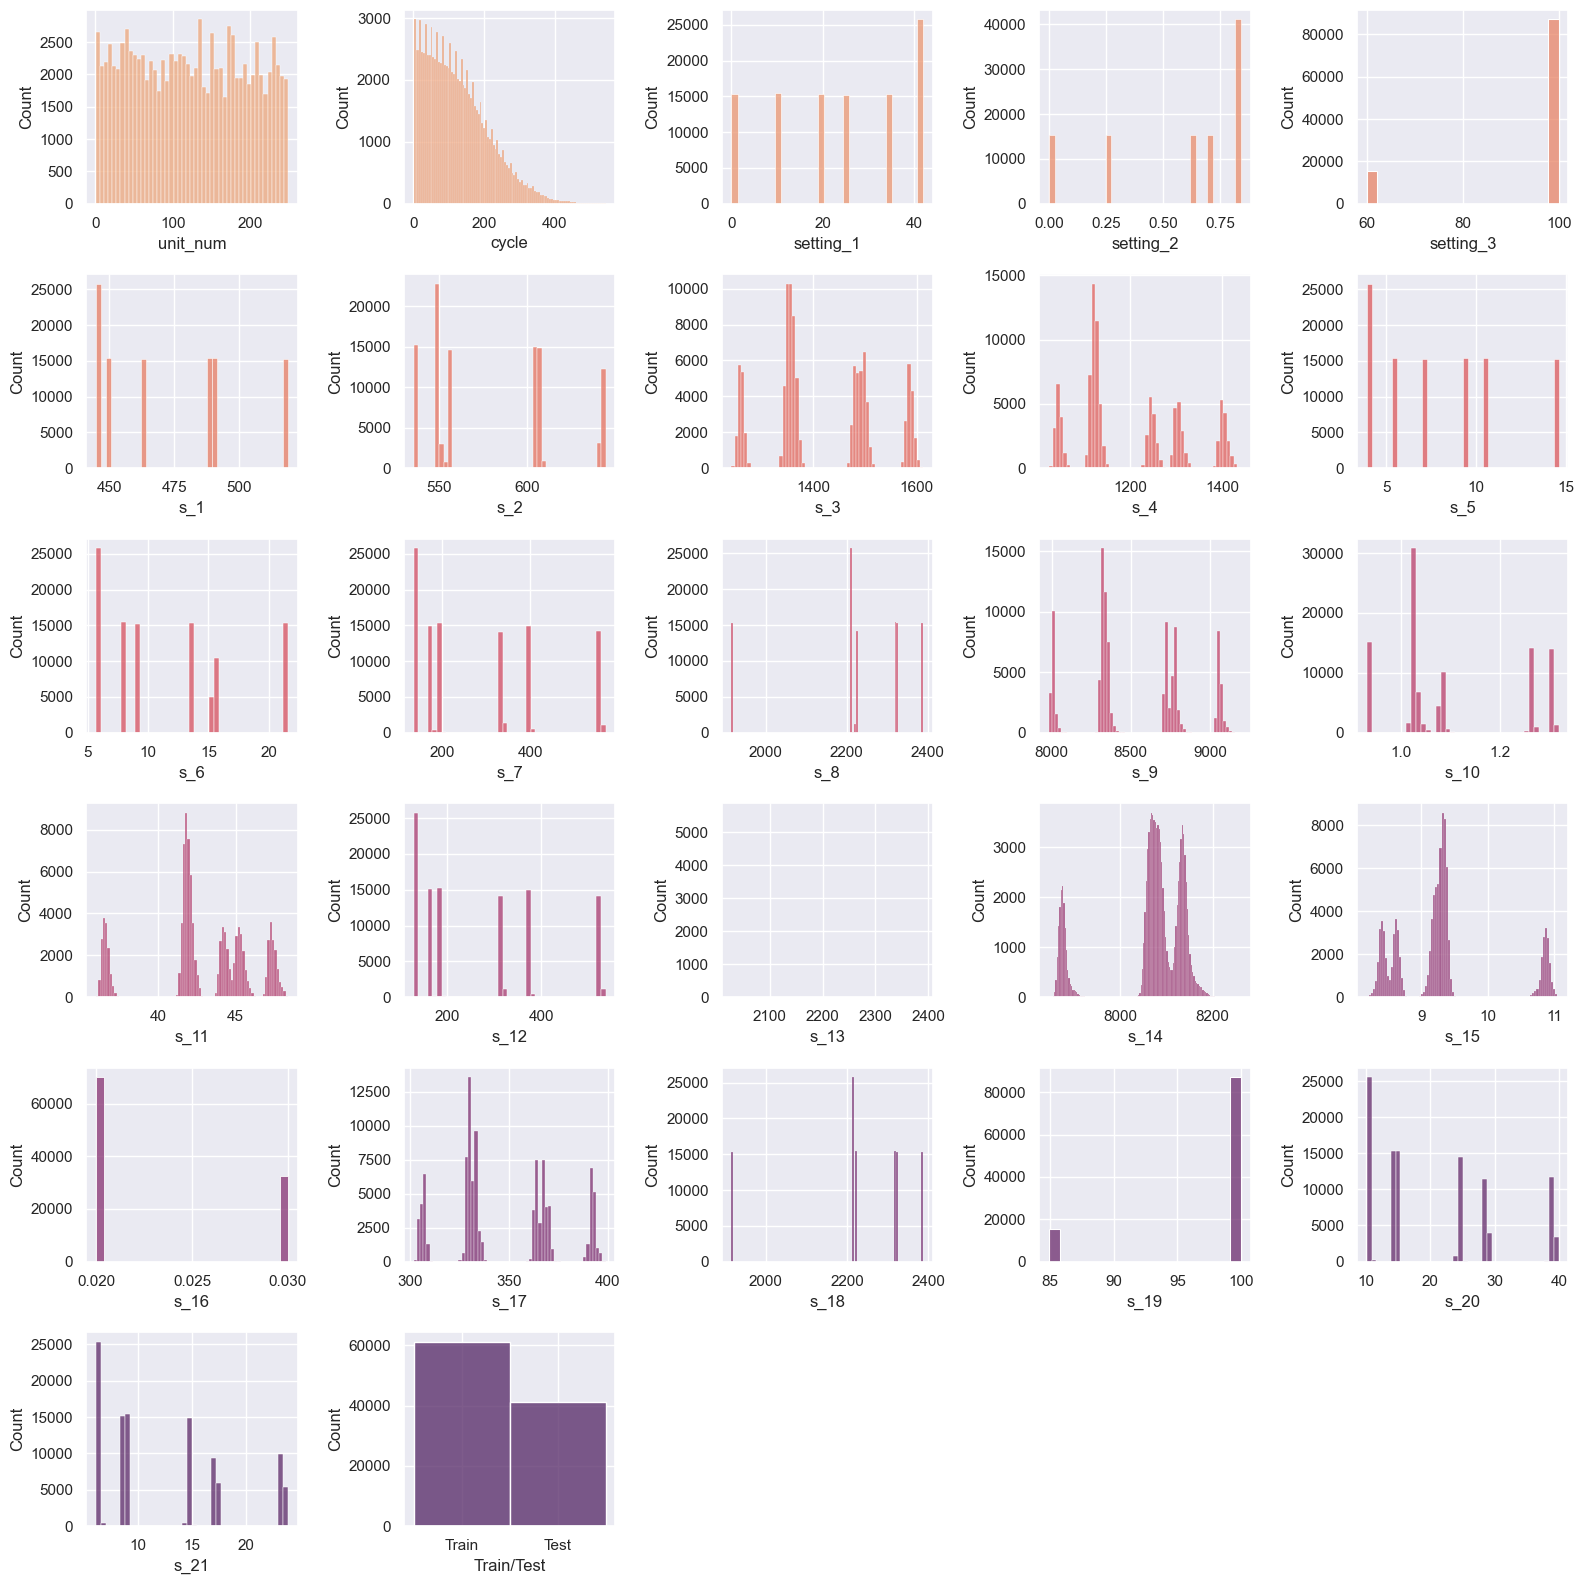

In [86]:
fig = plt.figure(figsize=[16, 16])
cols = data.columns
cnt = 1

palette = sns.color_palette("flare", len(cols))

for col, color in zip(cols, palette):
    plt.subplot(6,5,cnt)
    sns.histplot(data[col], color=color)
    cnt += 1

plt.tight_layout()
plt.show()


Se puede observar claramente la existencia de diversas distribuciones dentro de una misma variable. Esta variabilidad podría atribuirse a las diversas condiciones operativas que son determinadas por los valores de los parámetros setting_1, setting_2 y setting_3. 
Sabemos de antemano que en este dataset se registraron valores de 6 condiciones operativas diferentes generadas con los parámetros de settings mencionados. Por ello, se procede a analizar dichas variables:

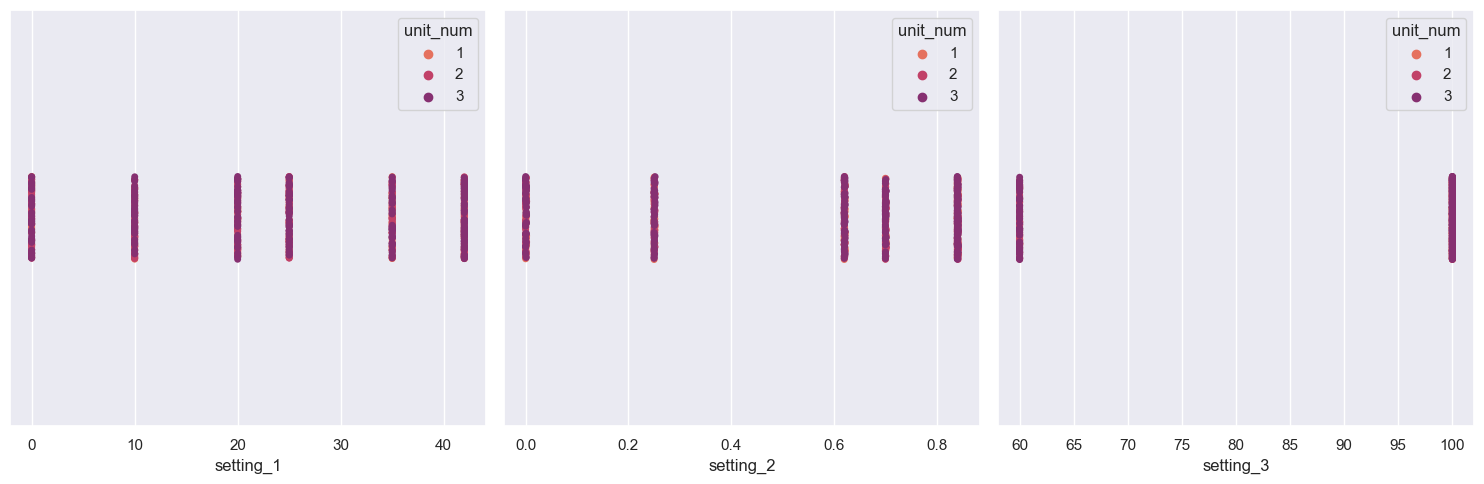

In [87]:
palette = sns.color_palette("flare", n_colors=3)
settings = ["setting_1", "setting_2", "setting_3"]
filtro=data[(data["unit_num"].isin([1, 2, 3])) & (data["Train/Test"] == "Train")]
    
plt.figure(figsize=(15,5))

for i, set in enumerate(settings):
    plt.subplot(1,3,i+1)
    sns.stripplot(data=filtro, x=set, hue="unit_num",palette=palette)
    plt.xlabel(f"{set}")
    
plt.tight_layout()    
plt.show()

En efecto, se detecta que los valores de los parámetros setting_1 y setting_2 presentan únicamente seis y cinco valores respectivamente (con cierto grado de ruido asociado) mientras que la variable setting_3 asume únicamente dos valores. Sin embargo, si bien se observa cierto ruido sabemos que se tratan de las mismas condiciones operativa. 
Como se ve en la tabla debajo, para el caso de setting_1 y setting_2, los valores dentro del mismo rango difieren únicamente en el tercer decimal, mientras que para setting_3 no se observa ruido en las dos posibles condiciones operativas.

In [88]:
print(data[settings].head(15))

    setting_1  setting_2  setting_3
0     42.0049     0.8400      100.0
1     20.0020     0.7002      100.0
2     42.0038     0.8409      100.0
3     42.0000     0.8400      100.0
4     25.0063     0.6207       60.0
5     34.9996     0.8400      100.0
6      0.0019     0.0001      100.0
7     41.9981     0.8400      100.0
8     42.0016     0.8400      100.0
9     25.0019     0.6217       60.0
10    20.0016     0.7000      100.0
11    34.9993     0.8400      100.0
12    24.9986     0.6200       60.0
13    20.0056     0.7008      100.0
14    25.0000     0.6200       60.0


A continuación, se redondearon los valores de setting_1 y setting_2 y se confirma que se manejan únicamente seis condiciones operativas en total (siendo cada condición una combinación posible de los valores de settings).

In [89]:
data["setting_1"]=data["setting_1"].round(decimals=1)
data["setting_2"]=data["setting_2"].round(decimals=2)

#Verificar combinaciones únicas
combinaciones_unicas = data.groupby(["setting_1", "setting_2", "setting_3"]).size().reset_index()
print("Número de combinaciones únicas:", len(combinaciones_unicas))
combinaciones_unicas

Número de combinaciones únicas: 6


setting_1  setting_2  setting_3      0
0        0.0       0.00      100.0  15292
1       10.0       0.25      100.0  15409
2       20.0       0.70      100.0  15345
3       25.0       0.62       60.0  15246
4       35.0       0.84      100.0  15394
5       42.0       0.84      100.0  25777

En el siguiente gráfico se estudió el comportamiento de los histogramas si los analizamos para cada condición operativa: 

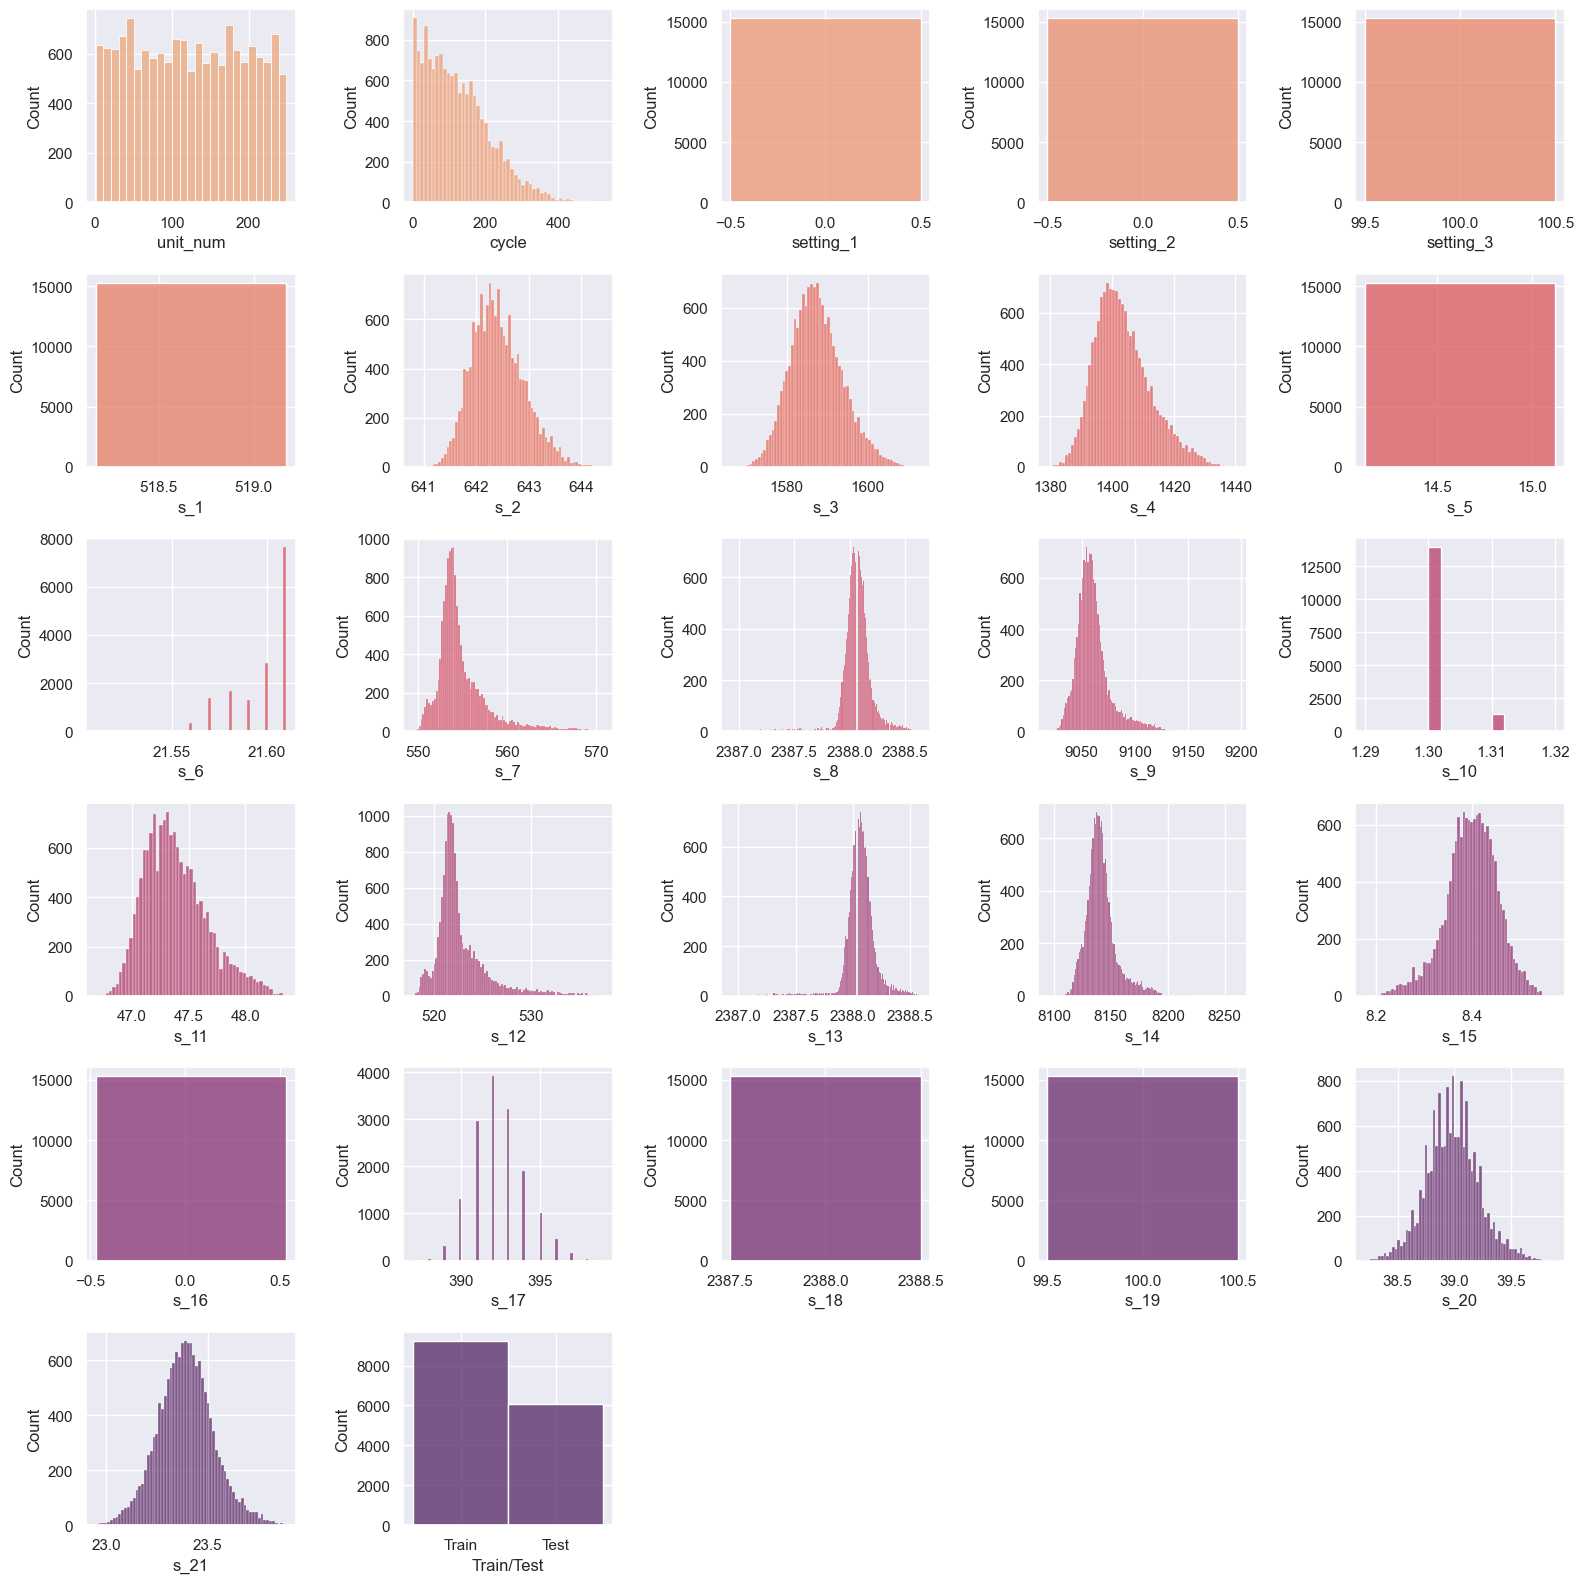

In [90]:
fig = plt.figure(figsize=[16, 16])
cols = data.columns
cnt = 1

palette = sns.color_palette("flare", len(cols))

filtro=data[(data["setting_1"]==combinaciones_unicas.iloc[0,0])&
            (data["setting_2"]==combinaciones_unicas.iloc[0,1])&
           (data["setting_3"]==combinaciones_unicas.iloc[0,2])]


for col, color in zip(cols, palette):
    plt.subplot(6,5,cnt)
    sns.histplot(filtro[col], color=color)
    cnt += 1

plt.tight_layout()
plt.show()



Del grafico anterior se detecta la existencia de sensores cuyos valores depende únicamente de la condición operativa, manteniendo a su vez un valor constante para cada condición (ejemplo s_1,s_5,s_16,s_18,s_19). Es decir, quedan totalmente predeterminadas por la condición de trabajo del equipo. 

### RELACIÓN ENTRE VARIABLES
**VARIABLE TARGET (RUL)**  

Dado que no se dispone de información directa sobre la RUL en el conjunto de datos de entrenamiento, sino sobre la cantidad de ciclos que un motor realiza antes de su fallo, se deben crear estimaciones. 

En los datos de entrenamiento, el último ciclo reportado para cada motor corresponde al ciclo en el que ocurre la falla, por lo tanto, en ese punto, la vida útil remanente es cero. En el ciclo anterior, sabemos que le queda un ciclo, en el ciclo previo a ese, le quedan dos, y así sucesivamente antes llegar al valor "clip" a partir del cual no se considera que haya degradación. La imputación de los valores de RUL se llevó a cabo de acuerdo a esta lógica. 

A continuación, se desarrolla una función para imputar los valores de la variable objetivo en los datos de entrenamiento. Esta función realiza los siguientes pasos:

- **Obtener el valor máximo de ciclos para cada motor**:  
Para cada motor en el conjunto de datos, se determina el valor máximo de ciclos al que ocurre la falla del equipo (último registro). Este valor representa el ciclo en el que el equipo experimenta la falla.

- **Crear una columna con el valor máximo de ciclos**:  
Se agrega una nueva columna a los registros de cada motor para almacenar el valor máximo de ciclos obtenido en el paso anterior. Esto permite tener una referencia clara para cada registro en relación con el tiempo hasta la falla del equipo.

- **Calcular la variable "RUL" (Remaining Useful Life)**:  
Se calcula una nueva variable llamada "RUL", que representa la vida útil restante del equipo. La "RUL" se calcula como la diferencia entre el valor máximo de ciclos y el valor actual del ciclo para cada registro. Esta variable comienza en cero para el último registro y aumenta a medida que disminuyen los ciclos restantes (hacia arriba).

- **Utilizar la función "clip" para limitar la RUL**:  
Se utiliza la función "clip" para limitar la variable "RUL" y demarcar el punto en el que ésta deja de aumentar (no degradación). 

Para profundizar en el motivo por el cual se utilzó un modelo de degradación lineal por tramos con un valor de corte de 125, referirse al **ANEXO B**.

In [91]:
def RUL_add(dataframe,clipped=False,early=None):
    if "unit_num" in dataframe.columns and "cycle" in dataframe.columns:

        df_rul=dataframe.groupby("unit_num")["cycle"].max().reset_index()
        df_rul.columns=["unit_num","max"]
        dataframe = pd.merge(dataframe, df_rul, on="unit_num")
        dataframe["RUL"]=dataframe["max"]-dataframe["cycle"]
        dataframe=dataframe.drop(labels="max",axis=1)

        if clipped:
             dataframe["RUL"]=dataframe["RUL"].clip(upper=early)

        return dataframe
    else:
        print("El dataframe debe contener las columnas unit_num y cycle")

En este punto, se vuelven a separar los conjuntos de entrenamiento y test:

In [92]:
train=data[(data["Train/Test"]=="Train")].drop(labels="Train/Test",axis=1) #igual al inicial excepto el redonde de settings
test=data[(data["Train/Test"]=="Test")].drop(labels="Train/Test",axis=1) #igual al inicial excepto el redonde de settings

print(f"""Tamaño conjunto de entrenamiento: {train.shape}
Tamaño conjunto de prueba: {test.shape}""")


Tamaño conjunto de entrenamiento: (61249, 26)
Tamaño conjunto de prueba: (41214, 26)


En base a lo comentado, se imputa la RUL utilizando la función creada y visualizando los datos para uno de los motores:

In [93]:
train=RUL_add(train,True,125)

#Visualización de los primeros y últimos datos para un motor dado:
train[train["unit_num"]==1][["unit_num","RUL"]].iloc[[1,2,3,316,317,318,319,320]]

unit_num  RUL
1           1  125
2           1  125
3           1  125
316         1    4
317         1    3
318         1    2
319         1    1
320         1    0

**VARIABLES CATEGÓRICAS**  

Como se observó anteriormente, las variables relacionadas con condiciones operativas presentan un rango limitado de valores (hasta seis). Aunque numéricas, estas cifras no siguen un orden lógico, sino que indican puntos específicos de funcionamiento. Por ello, es recomendable tratarlas como categóricas, dadas su naturaleza discreta y el objetivo de representar estados de trabajo distintos.

A continuación se verifican las frecuencias de aparición de cada clase para verificar si existe alguna poco representada (menor a 2-5%).

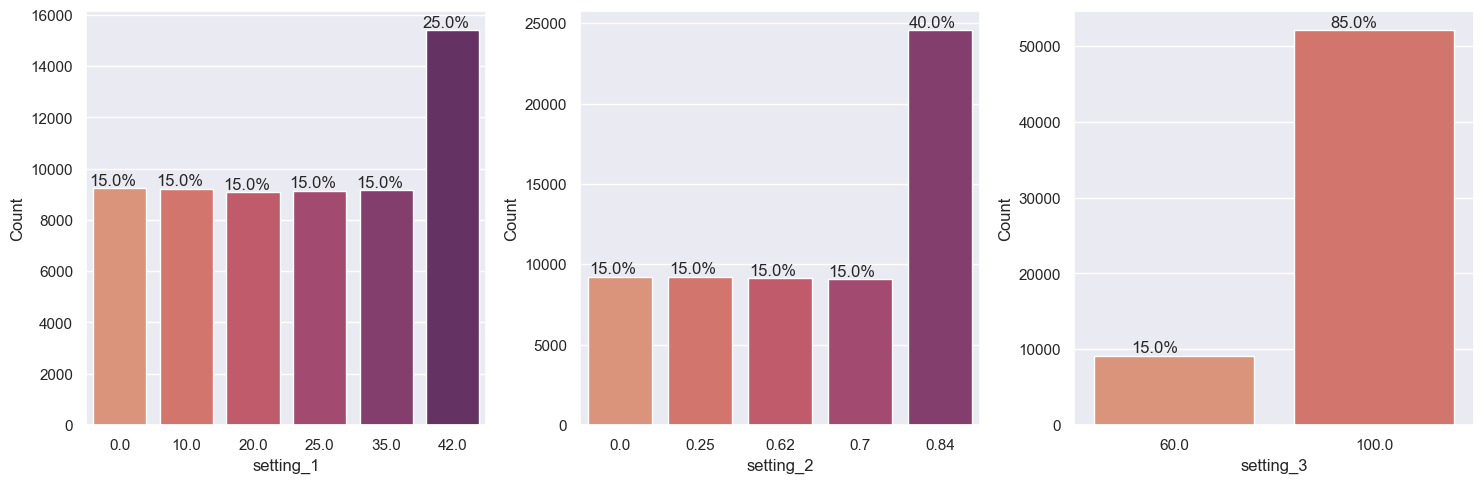

In [94]:
palette = sns.color_palette("flare")
cat_cols=settings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(cat_cols):
    ax = sns.countplot(data=train, x=col, palette=palette, ax=axes[i])
    ax.set_ylabel("Count")
    
    frecuencias = train[col].value_counts().reset_index()
    frecuencias.columns = ["Value", "Count"]
    frecuencias["Percentage"] = round((frecuencias["Count"] / train.shape[0]) * 100,0)
    frecuencias = frecuencias.sort_values(by="Value")
    
    for p, percentage in zip(ax.patches, frecuencias["Percentage"]):
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height()
        ax.annotate(f"{percentage:.1f}%", (x, y), fontsize=12, ha="center", va="bottom")

plt.tight_layout()
plt.show()

Habiendo verificado que todas las clases están bien representadas se procedió a analizar la relación entre dichas variables y la variable objetivo (RUL):

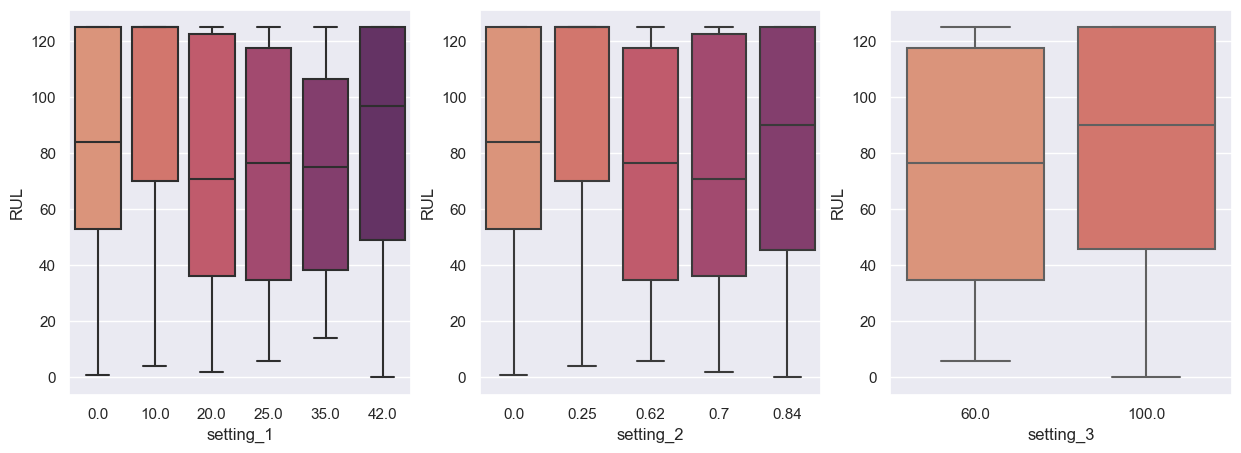

In [95]:
#Categóricas vs target
palette = sns.color_palette("flare")
cat_cols=settings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

unidades_ejemplo=[45]
for i, col in enumerate(cat_cols):
    sns.boxplot(data=train[train["unit_num"].isin(unidades_ejemplo)], x=col, y="RUL", palette=palette, ax=axes[i])

plt.show()

Se identifica que existe relación entre estas variables y la objetivo ya que se puede apreciar diferentes valores de las medidas centrales, como por ejemplo la mediana, entre las distintas categorías. 

**VARIABLES NUMÉRICAS**  

Para analizar las variables numéricas se realizó un gráfico de dispersión entre cada sensor y la vida útil remanente:

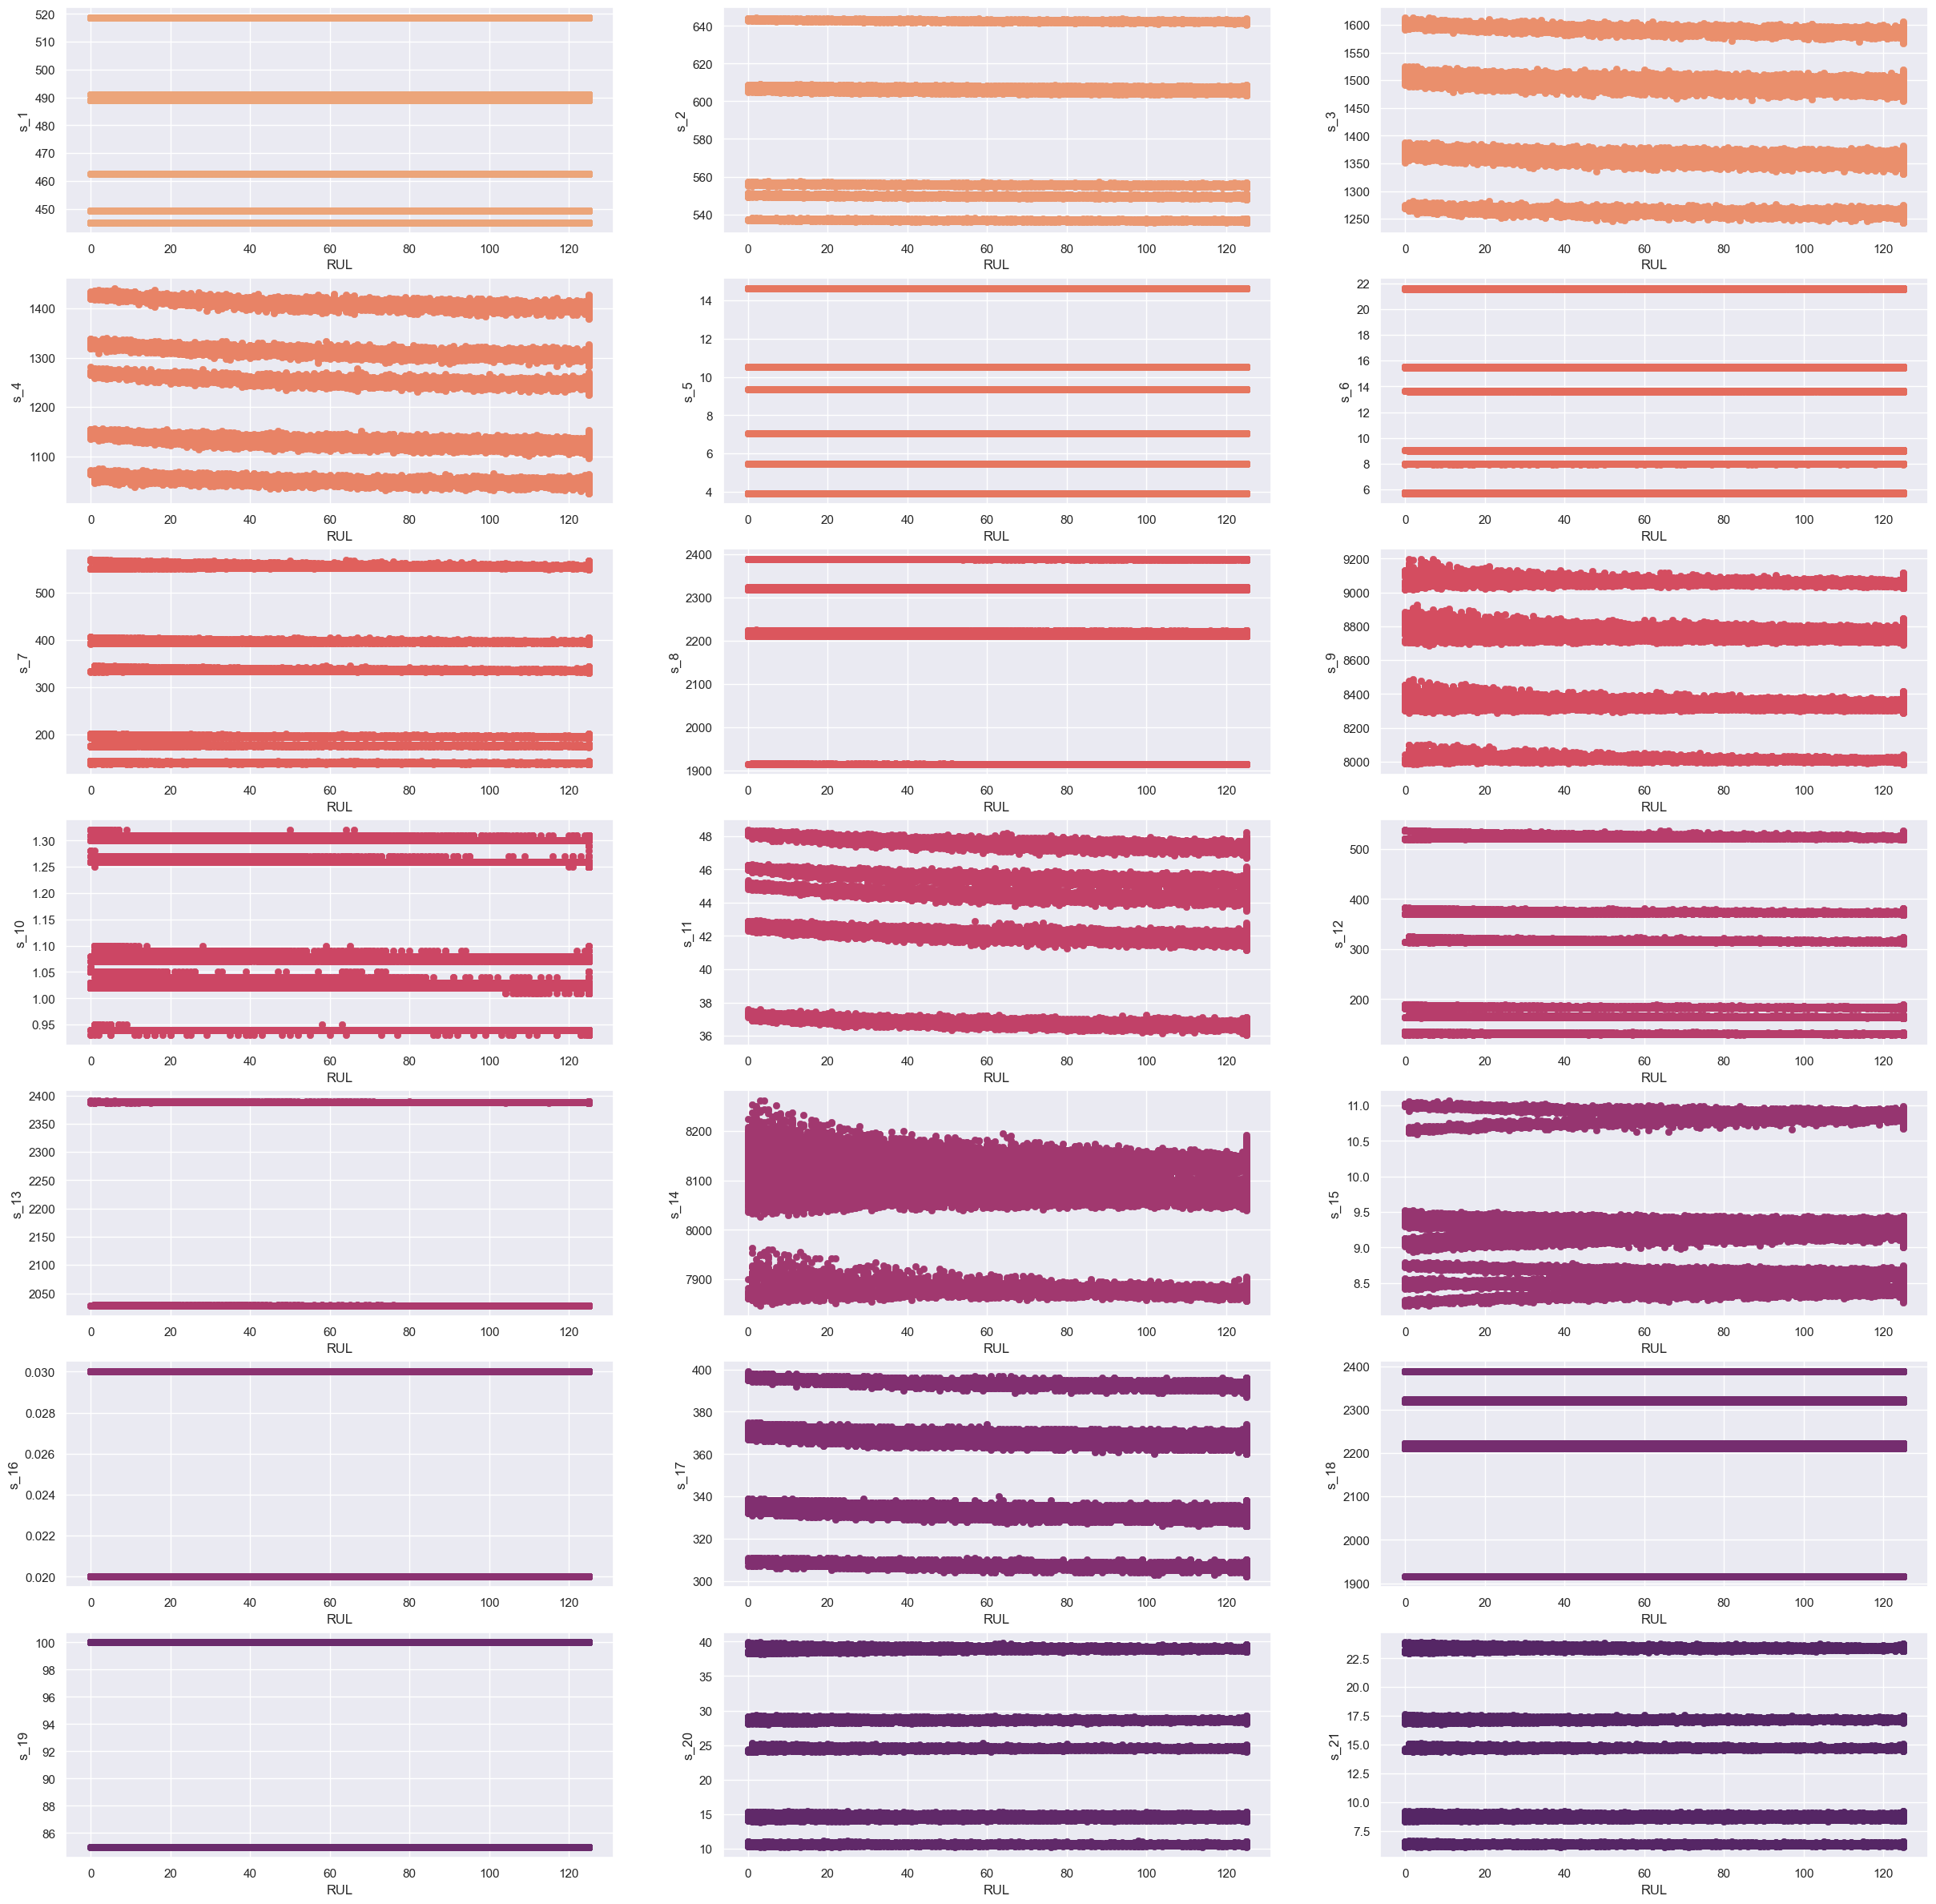

In [96]:
#Numéricas vs target 
palette = sns.color_palette("flare", n_colors=len(sensor))
plt.figure(figsize=(30,30))

for i,sen in enumerate(sensor):
    plt.subplot(7,3,i+1)
    sns.scatterplot(data=train,x="RUL",y=sen,color=palette[i], edgecolor=None)

plt.show()

Al igual que antes, se observa que en general los sensores toman diferentes rangos de valores, posiblemente en función de cada condición de operación. Es de esperar que en condiciones más o menos exigidas la temperatura presión, etc. trabajen en diferente rango. 
Se procede a crear una variable "condición_op" que representa cada una de las seis posibles combinaciones de los valores de settings. Lo anterior se realiza con el objetivo de analizar más de cerca la relación sensor vs RUL, segregando por condición operativa.

In [97]:
train["condición_op"] = train["setting_1"].astype(str) + "_" + \
                        train["setting_2"].astype(str) + "_" + \
                        train["setting_3"].astype(str)

In [98]:
train["condición_op"].unique()

array(['42.0_0.84_100.0', '20.0_0.7_100.0', '25.0_0.62_60.0',
       '35.0_0.84_100.0', '0.0_0.0_100.0', '10.0_0.25_100.0'],
      dtype=object)

El grafico inferior muestra la relación entre el sensor_2 y la variable objetivo, demarcando cada condición operativa:

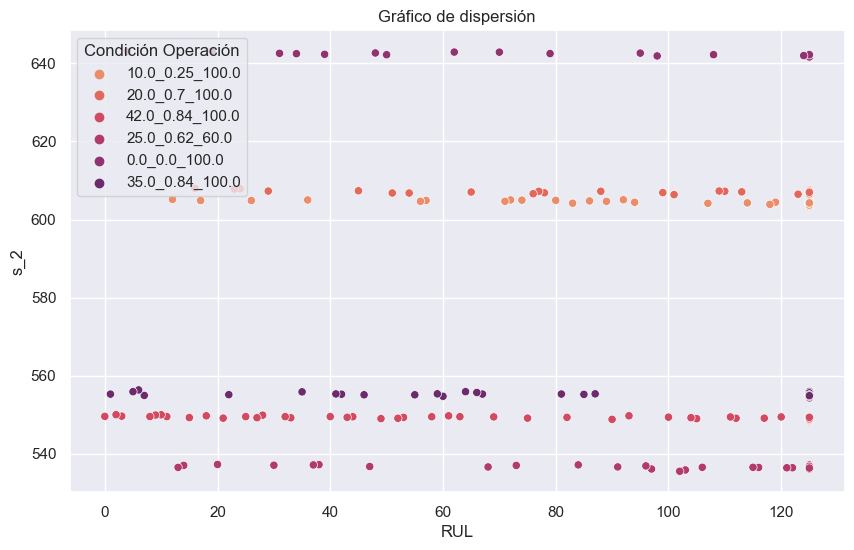

In [106]:
unit_num=[10]
sensores=["s_2"]

filtro = train[train["unit_num"].isin(unit_num)]
palette = sns.color_palette("flare", 6)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtro, y="s_2", x="RUL", hue="condición_op", palette=palette)
plt.legend(title="Condición Operación")
plt.ylabel("s_2")
plt.title("Gráfico de dispersión")

plt.show()

Efectivamente los diferentes valores corresponden a diferentes condiciones de operación. Se verifica si lo anterior sucede para todos los sensores:

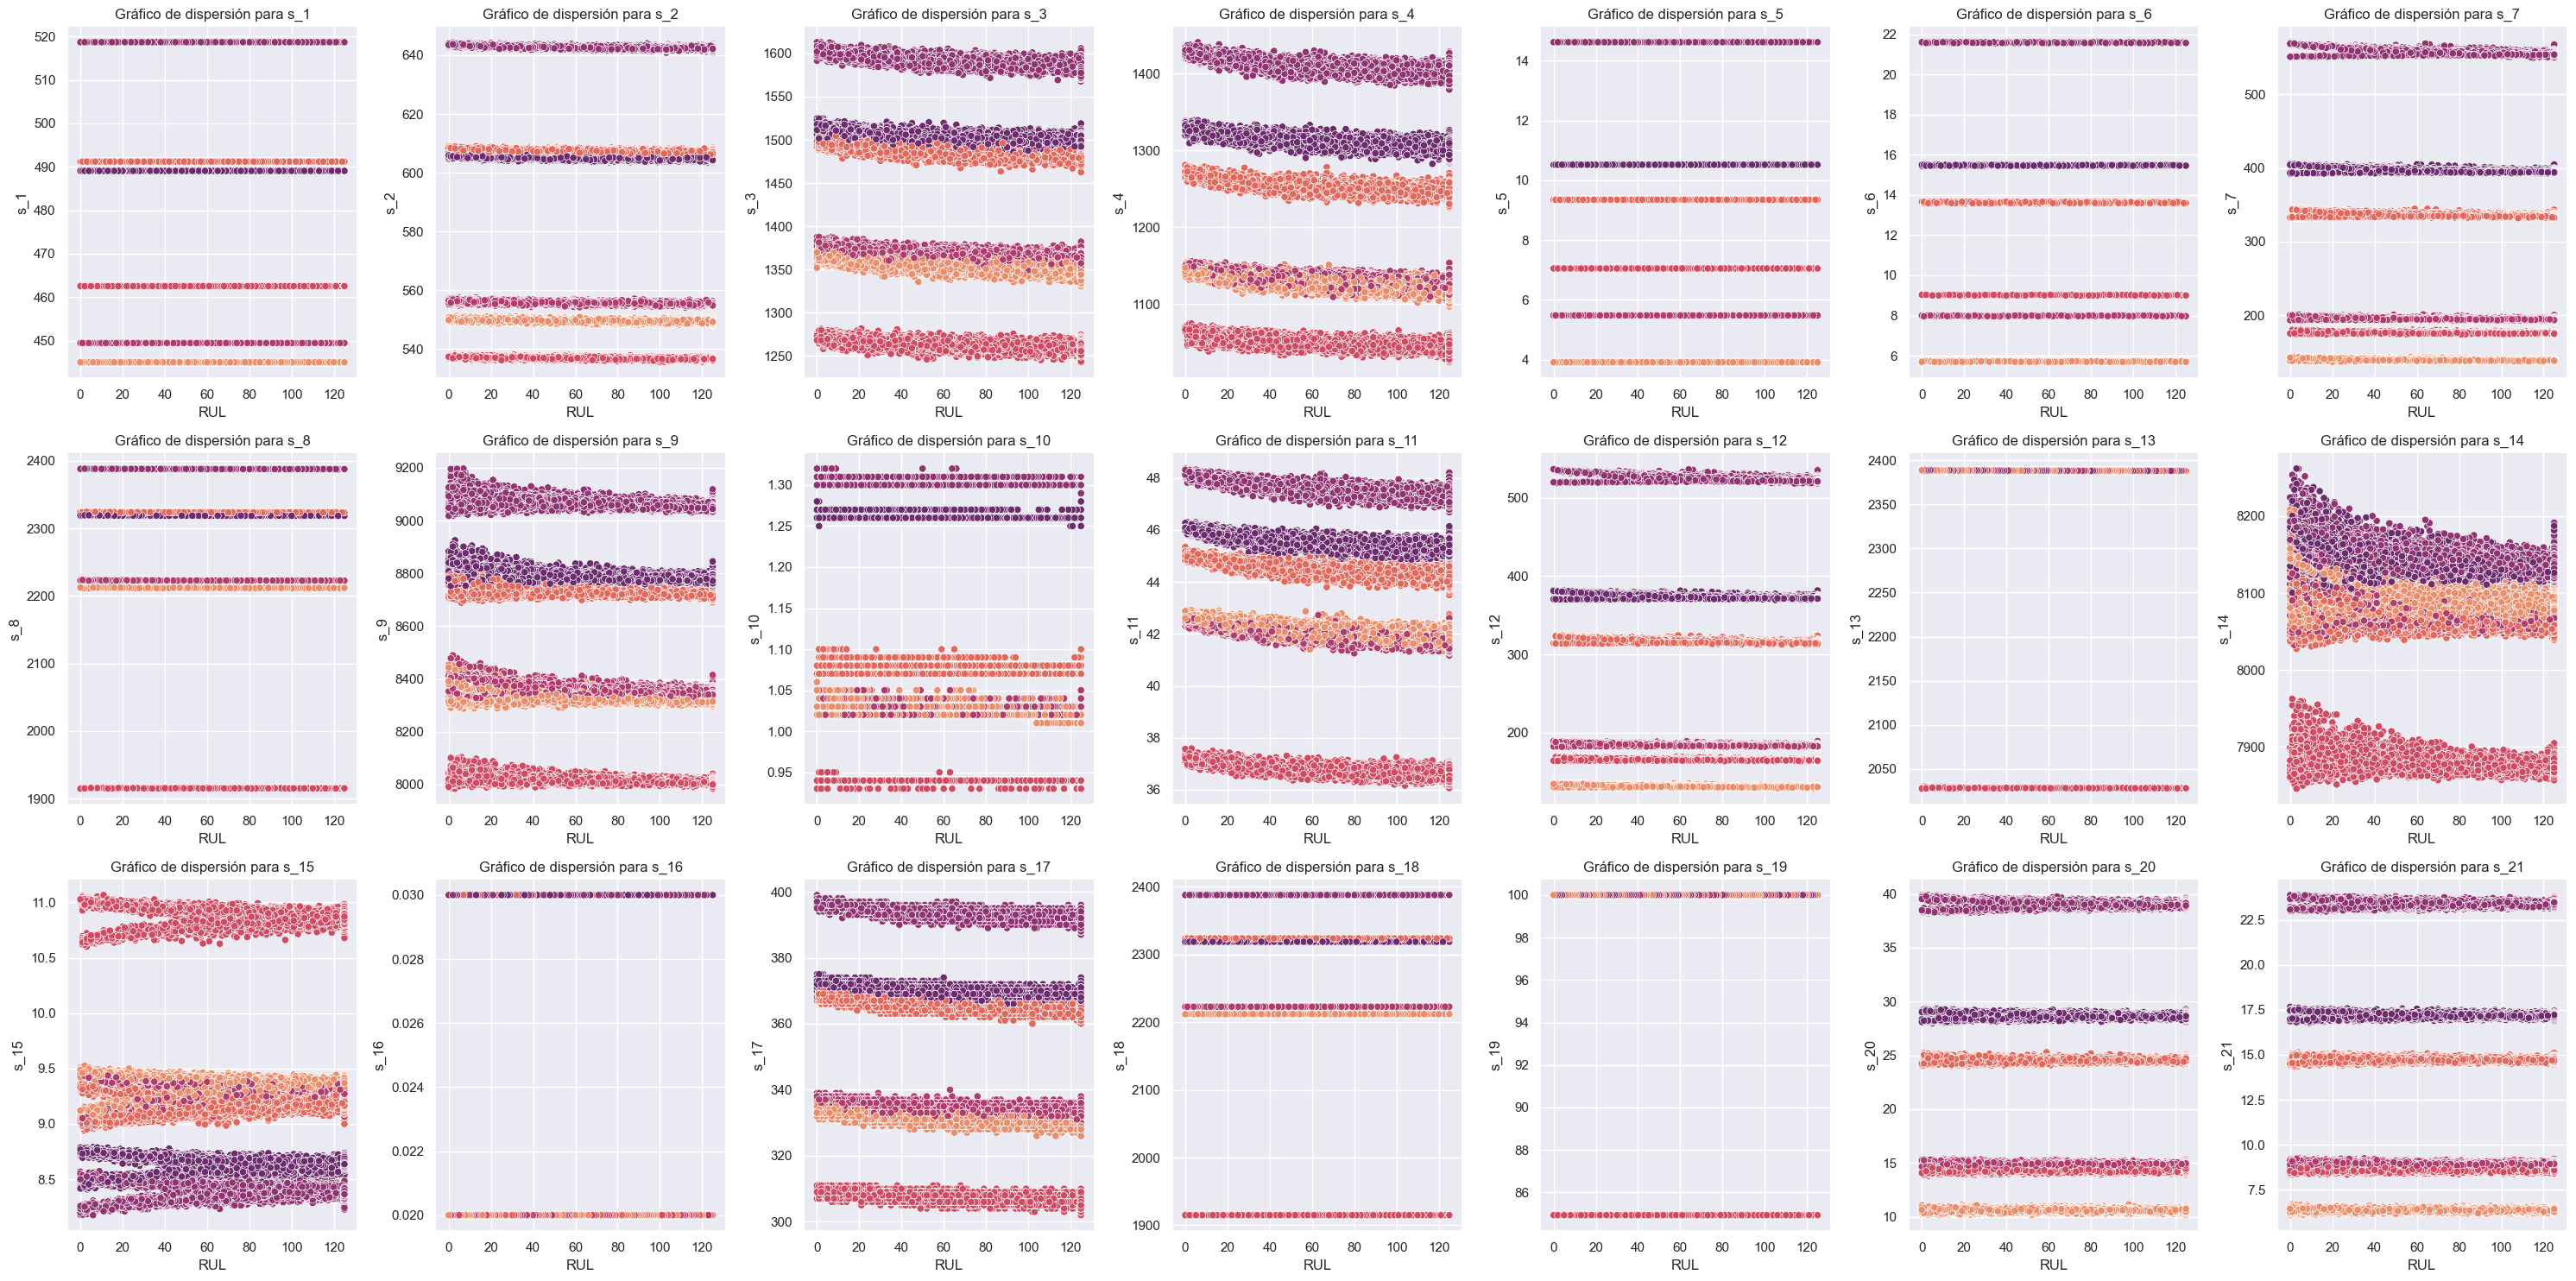

In [107]:
#Abanico a graficar: cantidad de unidades: todas /cantidad de sensores: todos
unit_num = train["unit_num"].unique()
sensors = ["s_1", "s_2", "s_3", "s_4", "s_5","s_6","s_7","s_8","s_9","s_10","s_11", "s_12","s_13","s_14","s_15","s_16","s_17","s_18","s_19","s_20","s_21"]

filtro = train[train["unit_num"].isin(unit_num)]
num_sensors = len(sensors)
num_rows, num_cols = divmod(num_sensors, 7)

palette = sns.color_palette("flare", 6)
if num_cols > 0:
    num_rows += 1

# Gráficos de dispersión para cada sensor
plt.figure(figsize=(30, 15))
for i, sensor in enumerate(sensors):
    plt.subplot(num_rows, 7, i+1)
    sns.scatterplot(data=filtro, y=sensor, x="RUL", hue="condición_op", palette=palette,legend=False)
    plt.ylabel(sensor)
    plt.title(f"Gráfico de dispersión para {sensor}")

plt.tight_layout()
plt.show()

En efecto, si graficamos todos los sensores se continúa obervando que la segregación en cuanto a rangos de operación corresponde a los settings. Ahora que entendemos mejor el comportamiento, veamos mejor la relación que hay entre los sensores y la variable target (RUL) más de cerca, ya que en los gráficos anteriores no es posible observar tendencias de forma clara.

In [126]:
def grafico_RUL_sensor(unit_num,sensors,condicion_op=None):
    #unit_num y sensores se introducen como vectores con las cantidades de motores y sensores a graficar respectivamente
    #condición_op: string con la condición de operación. Si esta vacío se grafican todas, demarcando cada categoría
    
    #selección de data
    filtro = train[train["unit_num"].isin(unit_num)]
    if condicion_op:
        filtro=filtro[filtro["condición_op"]==condicion_op]
        num_sensors = len(sensors)
        num_rows, num_cols = divmod(num_sensors, 7)
        if num_cols > 0:
            num_rows += 1

    # Gráficos de dispersión para cada sensor
        plt.figure(figsize=(30, 15))
        palette = sns.color_palette("flare", len(sensors))
        for i, sensor in enumerate(sensors):
            plt.subplot(num_rows, 7, i+1)
            sns.scatterplot(data=filtro, y=sensor, x="RUL", color=palette[i])
            plt.ylabel(sensor)
            plt.title(f"Gráfico de dispersión para {sensor}")
    else:
        filtro=filtro
        num_sensors = len(sensors)
        num_rows, num_cols = divmod(num_sensors, 7)
        if num_cols > 0:
            num_rows += 1

    # Gráficos de dispersión para cada sensor
        plt.figure(figsize=(30, 15))
        palette = sns.color_palette("flare", 6)
        for i, sensor in enumerate(sensors):
            plt.subplot(num_rows, 7, i+1)
            sns.scatterplot(data=filtro, y=sensor, x="RUL", hue="condición_op",palette=palette)
            plt.ylabel(sensor)
            plt.title(f"Gráfico de dispersión para {sensor}")

    plt.tight_layout()
    plt.show()


A continuación visualiza el gráfico para todos los sensores y todas las unidades de motor, pero para una únca condición operativa:

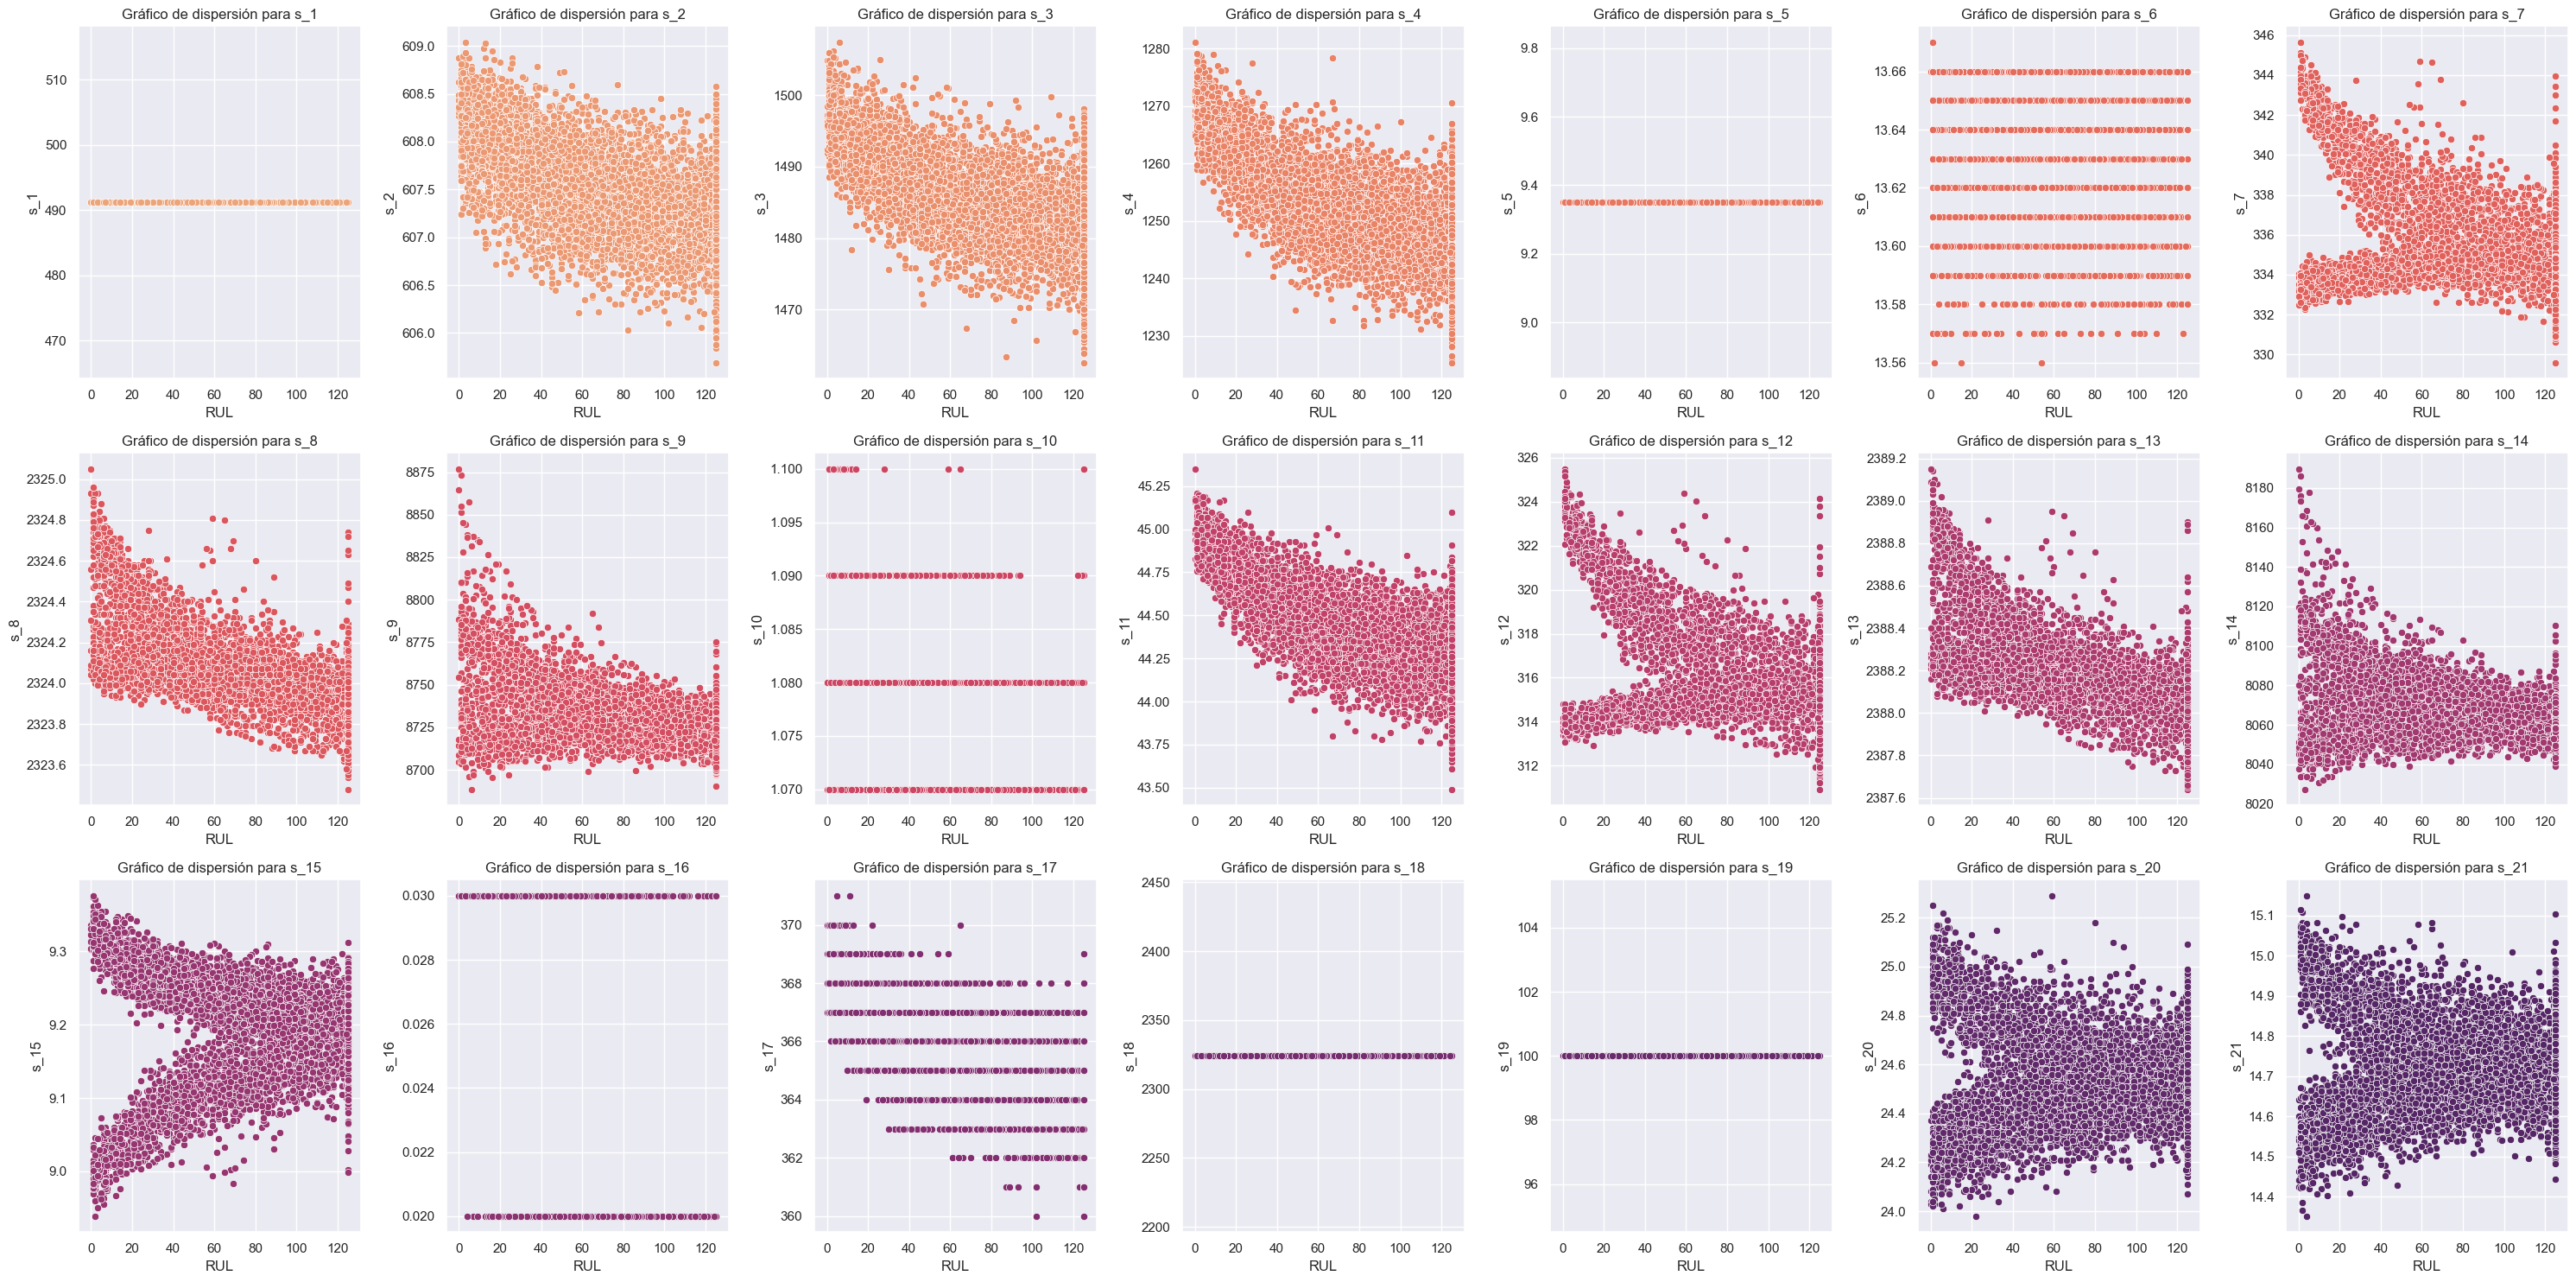

In [110]:
#Sensores: todos, motores: todos, condiciónes operativas: una 
unit_num = train["unit_num"].unique()
sensors = ["s_1", "s_2", "s_3", "s_4", "s_5","s_6","s_7","s_8","s_9","s_10","s_11", "s_12","s_13","s_14","s_15","s_16","s_17","s_18","s_19","s_20","s_21"]
condicion_op=train["condición_op"].unique()[1]

grafico_RUL_sensor(unit_num,sensors,condicion_op)

Como se indicó inicialmente, hay valores que están totalmente predeterminados por la condición operativa y por tanto se mantienen constantes. Estos son los sensores 1,5,16,18 y19. En el gráfico debajo se puede observar cada uno de ellos y sus valor predeterminado para cada condición operativa:

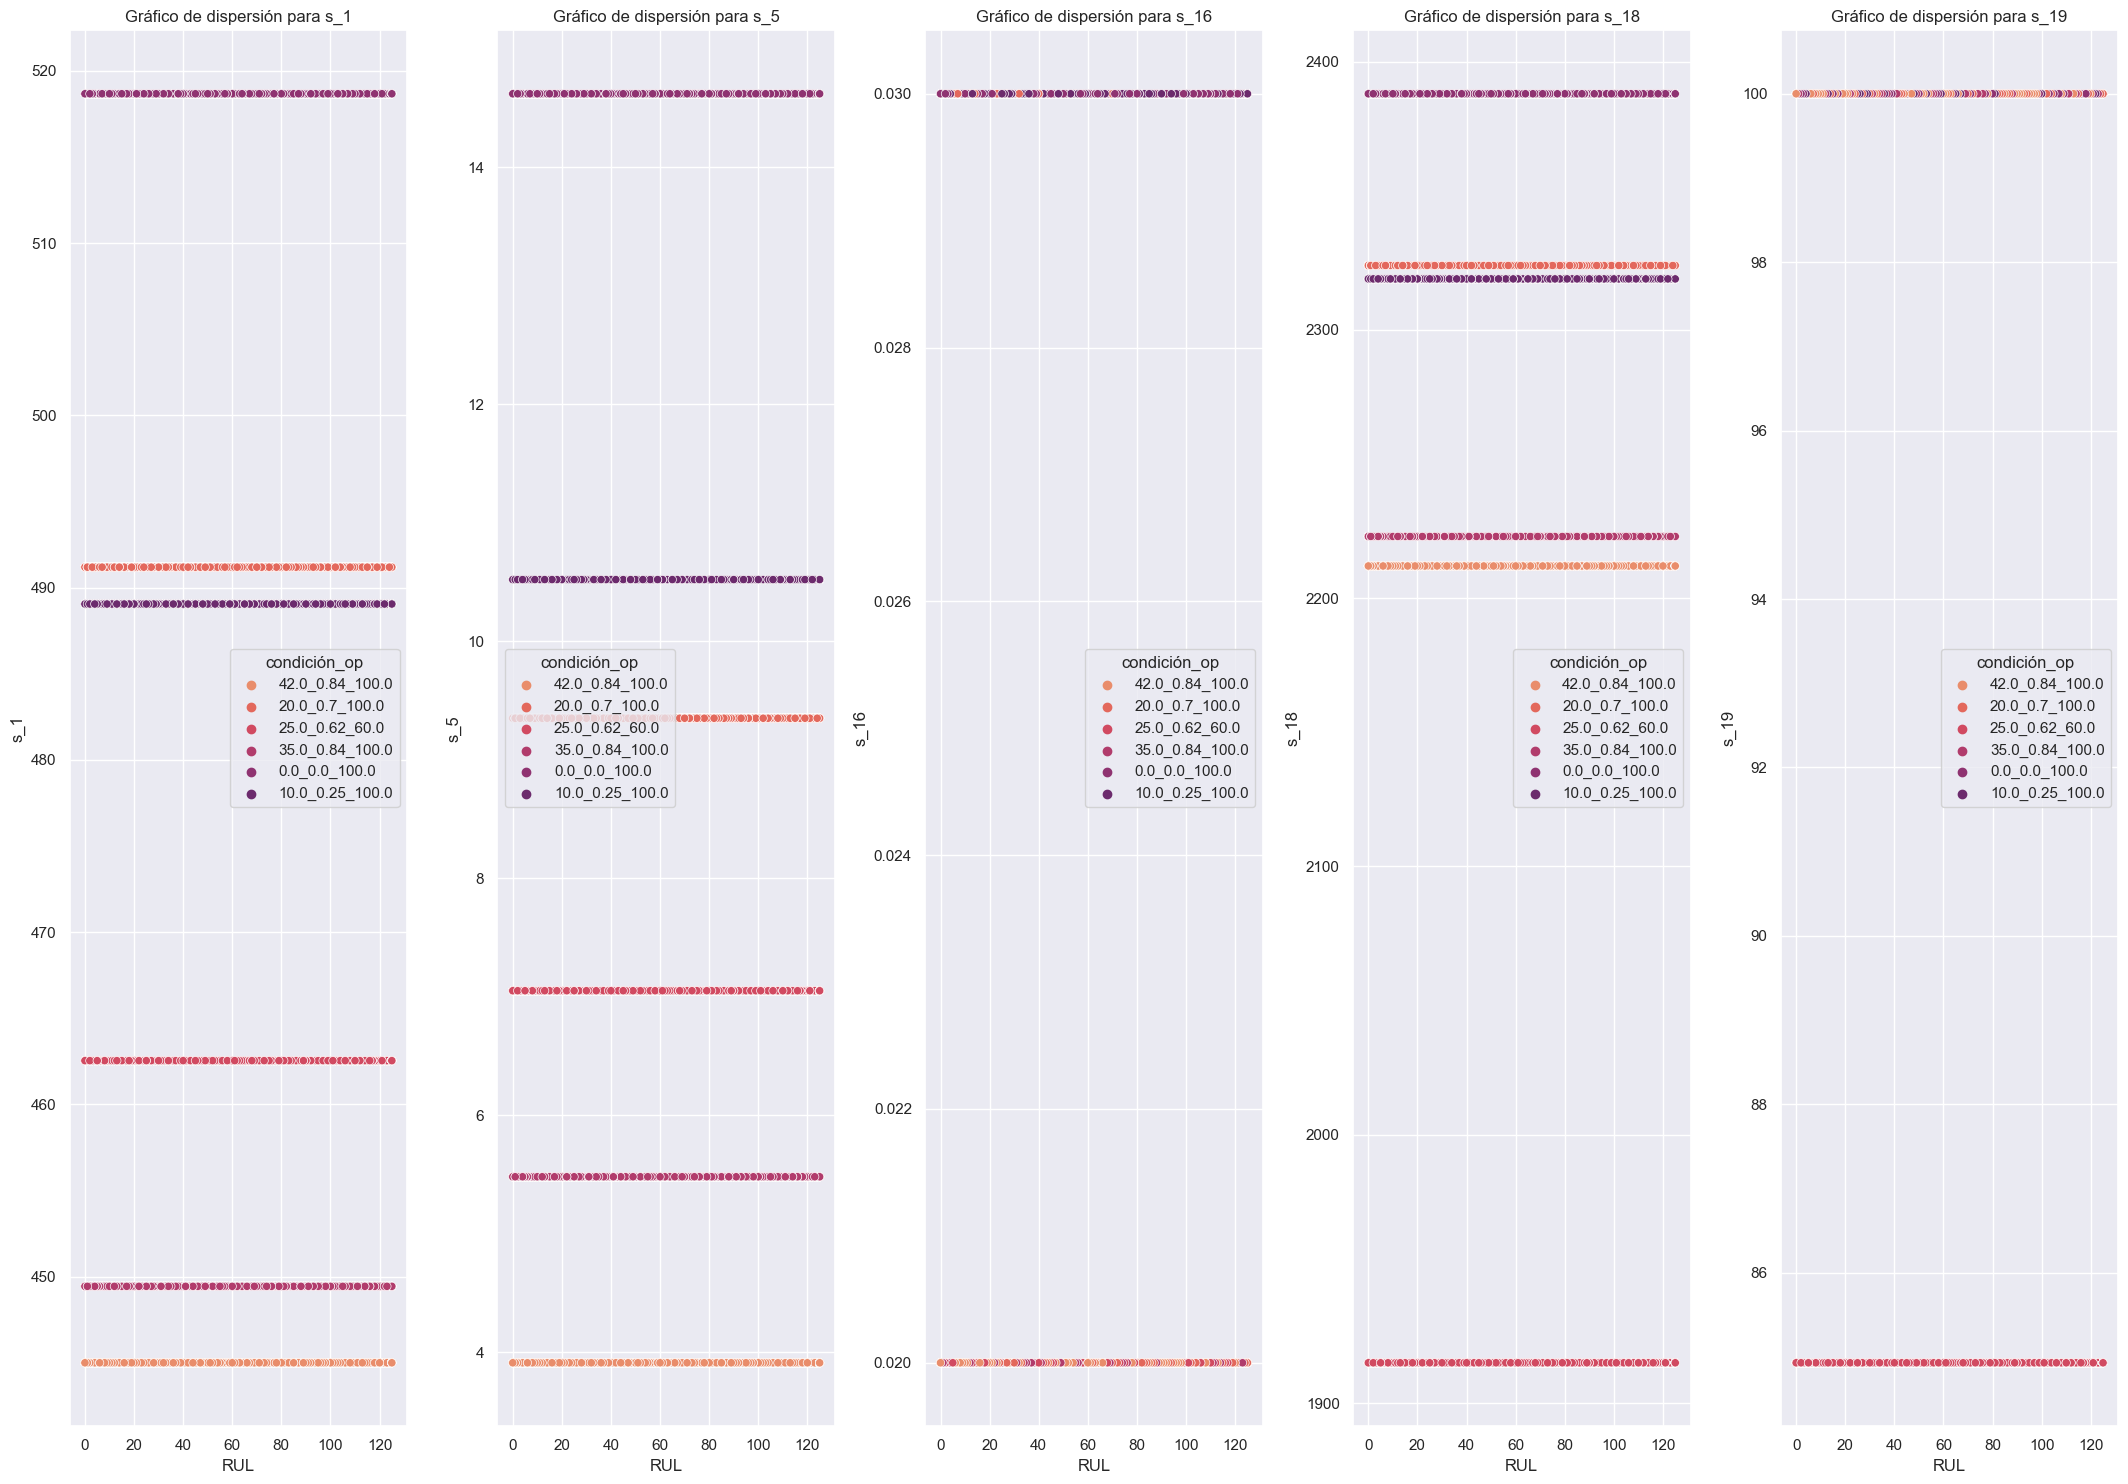

In [127]:
#Sensores: 1,5,16,18 y19, motores: todos, condiciónes operativas: todas 
unit_num = train["unit_num"].unique()
sensors = ["s_1", "s_5","s_16","s_18","s_19"]

grafico_RUL_sensor(unit_num,sensors,None)

A continuación, se procedió a analizar la relación de los demás sensores con la variable objetivo, graficando solamente algunos motores. El gráfico sería equivalente al visto anteriormente, pero con menos puntos para visualizar de forma más clara las tendencias.
Se realiza una nuva función, a efectos de diferenciar por número de motor, en lugar de por condición operativa: 

In [122]:
def grafico_RUL_sensor(unit_num, sensors, condicion_op=None):

    # selección de datos
    filtro = train[train["unit_num"].isin(unit_num)]
    if condicion_op:
        filtro = filtro[filtro["condición_op"] == condicion_op]

    num_sensors = len(sensors)
    num_rows, num_cols = divmod(num_sensors, 3)
    if num_cols > 0:
        num_rows += 1

    # Gráficos de dispersión para cada sensor
    plt.figure(figsize=(20, 15))
    if condicion_op:
        colors = sns.color_palette("flare", len(unit_num))
        for i, sensor in enumerate(sensors):
            plt.subplot(num_rows, 3, i + 1)
            for j, num in enumerate(unit_num):
                sns.scatterplot(data=filtro[filtro["unit_num"] == num], y=sensor, x="RUL", color=colors[j])
            plt.ylabel(sensor)
            plt.title(f"Gráfico de dispersión para {sensor}")
    else:
        for i, sensor in enumerate(sensors):
            plt.subplot(num_rows, 3, i + 1)
            sns.scatterplot(data=filtro, y=sensor, x="RUL")
            plt.ylabel(sensor)
            plt.title(f"Gráfico de dispersión para {sensor}")

    plt.tight_layout()
    plt.show()


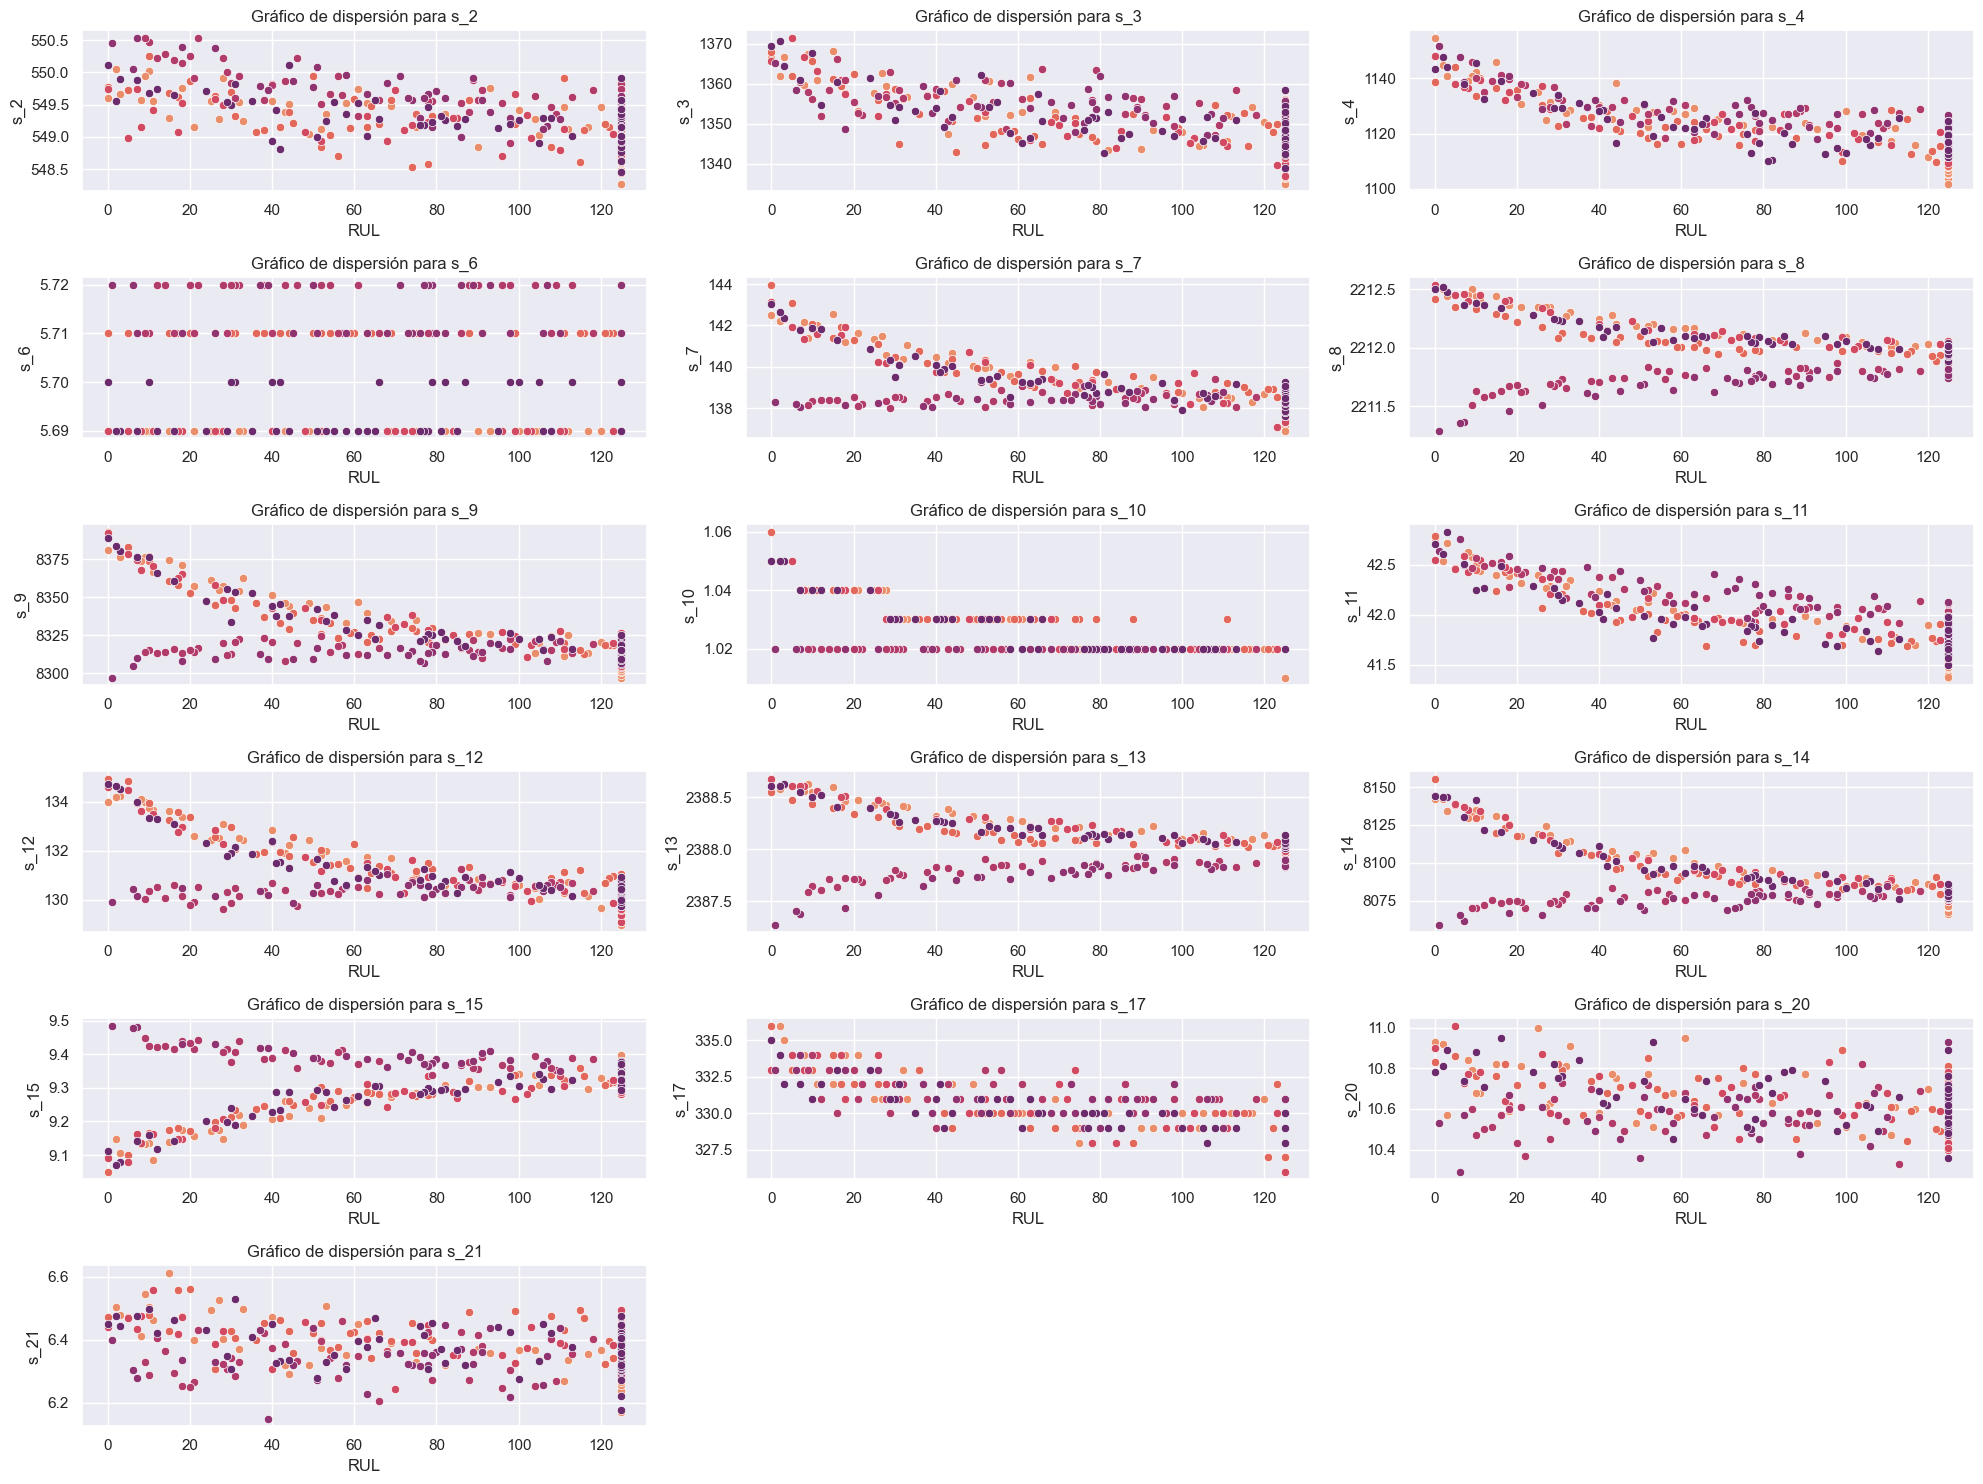

In [123]:
#Sensores: todos menos 1,5,16,18 y19, motores: 10,50,100,150,170,200, condiciónes operativas: una 
unit_num = [10,50,100,150,170,200]
sensors = ["s_2", "s_3", "s_4","s_6","s_7","s_8","s_9","s_10","s_11", "s_12","s_13","s_14","s_15","s_17","s_20","s_21"]
condicion_op=train["condición_op"].unique()[0]


grafico_RUL_sensor(unit_num,sensors,condicion_op)

Del anterior gráfico se extraen las siguientes observaciones:

1. Para los sensores 2, 3, 4, 11 y 17, se percibe una tendencia similar en la que valores más altos de estos sensores parecen estar asociados con valores más bajos de RUL.
2. Los sensores 7, 8, 9, 12, 13, 14 y 15 también muestran una tendencia en relación con RUL, pero es importante destacar que estas tendencias varían entre distintos motores. Esto sugiere la posibilidad de una diferenciación entre los dos modos de fallas que podrían ocurrir.
3. En contraste, los sensores 6, 10, 20 y 21 no presentan una tendencia clara en relación con RUL. Por lo tanto, será esencial realizar un análisis más detallado de estos sensores en la sección de selección de variables.


Se analizaron también las correlaciones estudiando la matriz de correlación e incluso estudiando los valores de Vcramer para entender más allá de relaciones lineales:

C:\Users\labor\AppData\Local\Temp/ipykernel_25036/2578678923.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),annot=True,cmap="flare",linewidths=0.1)


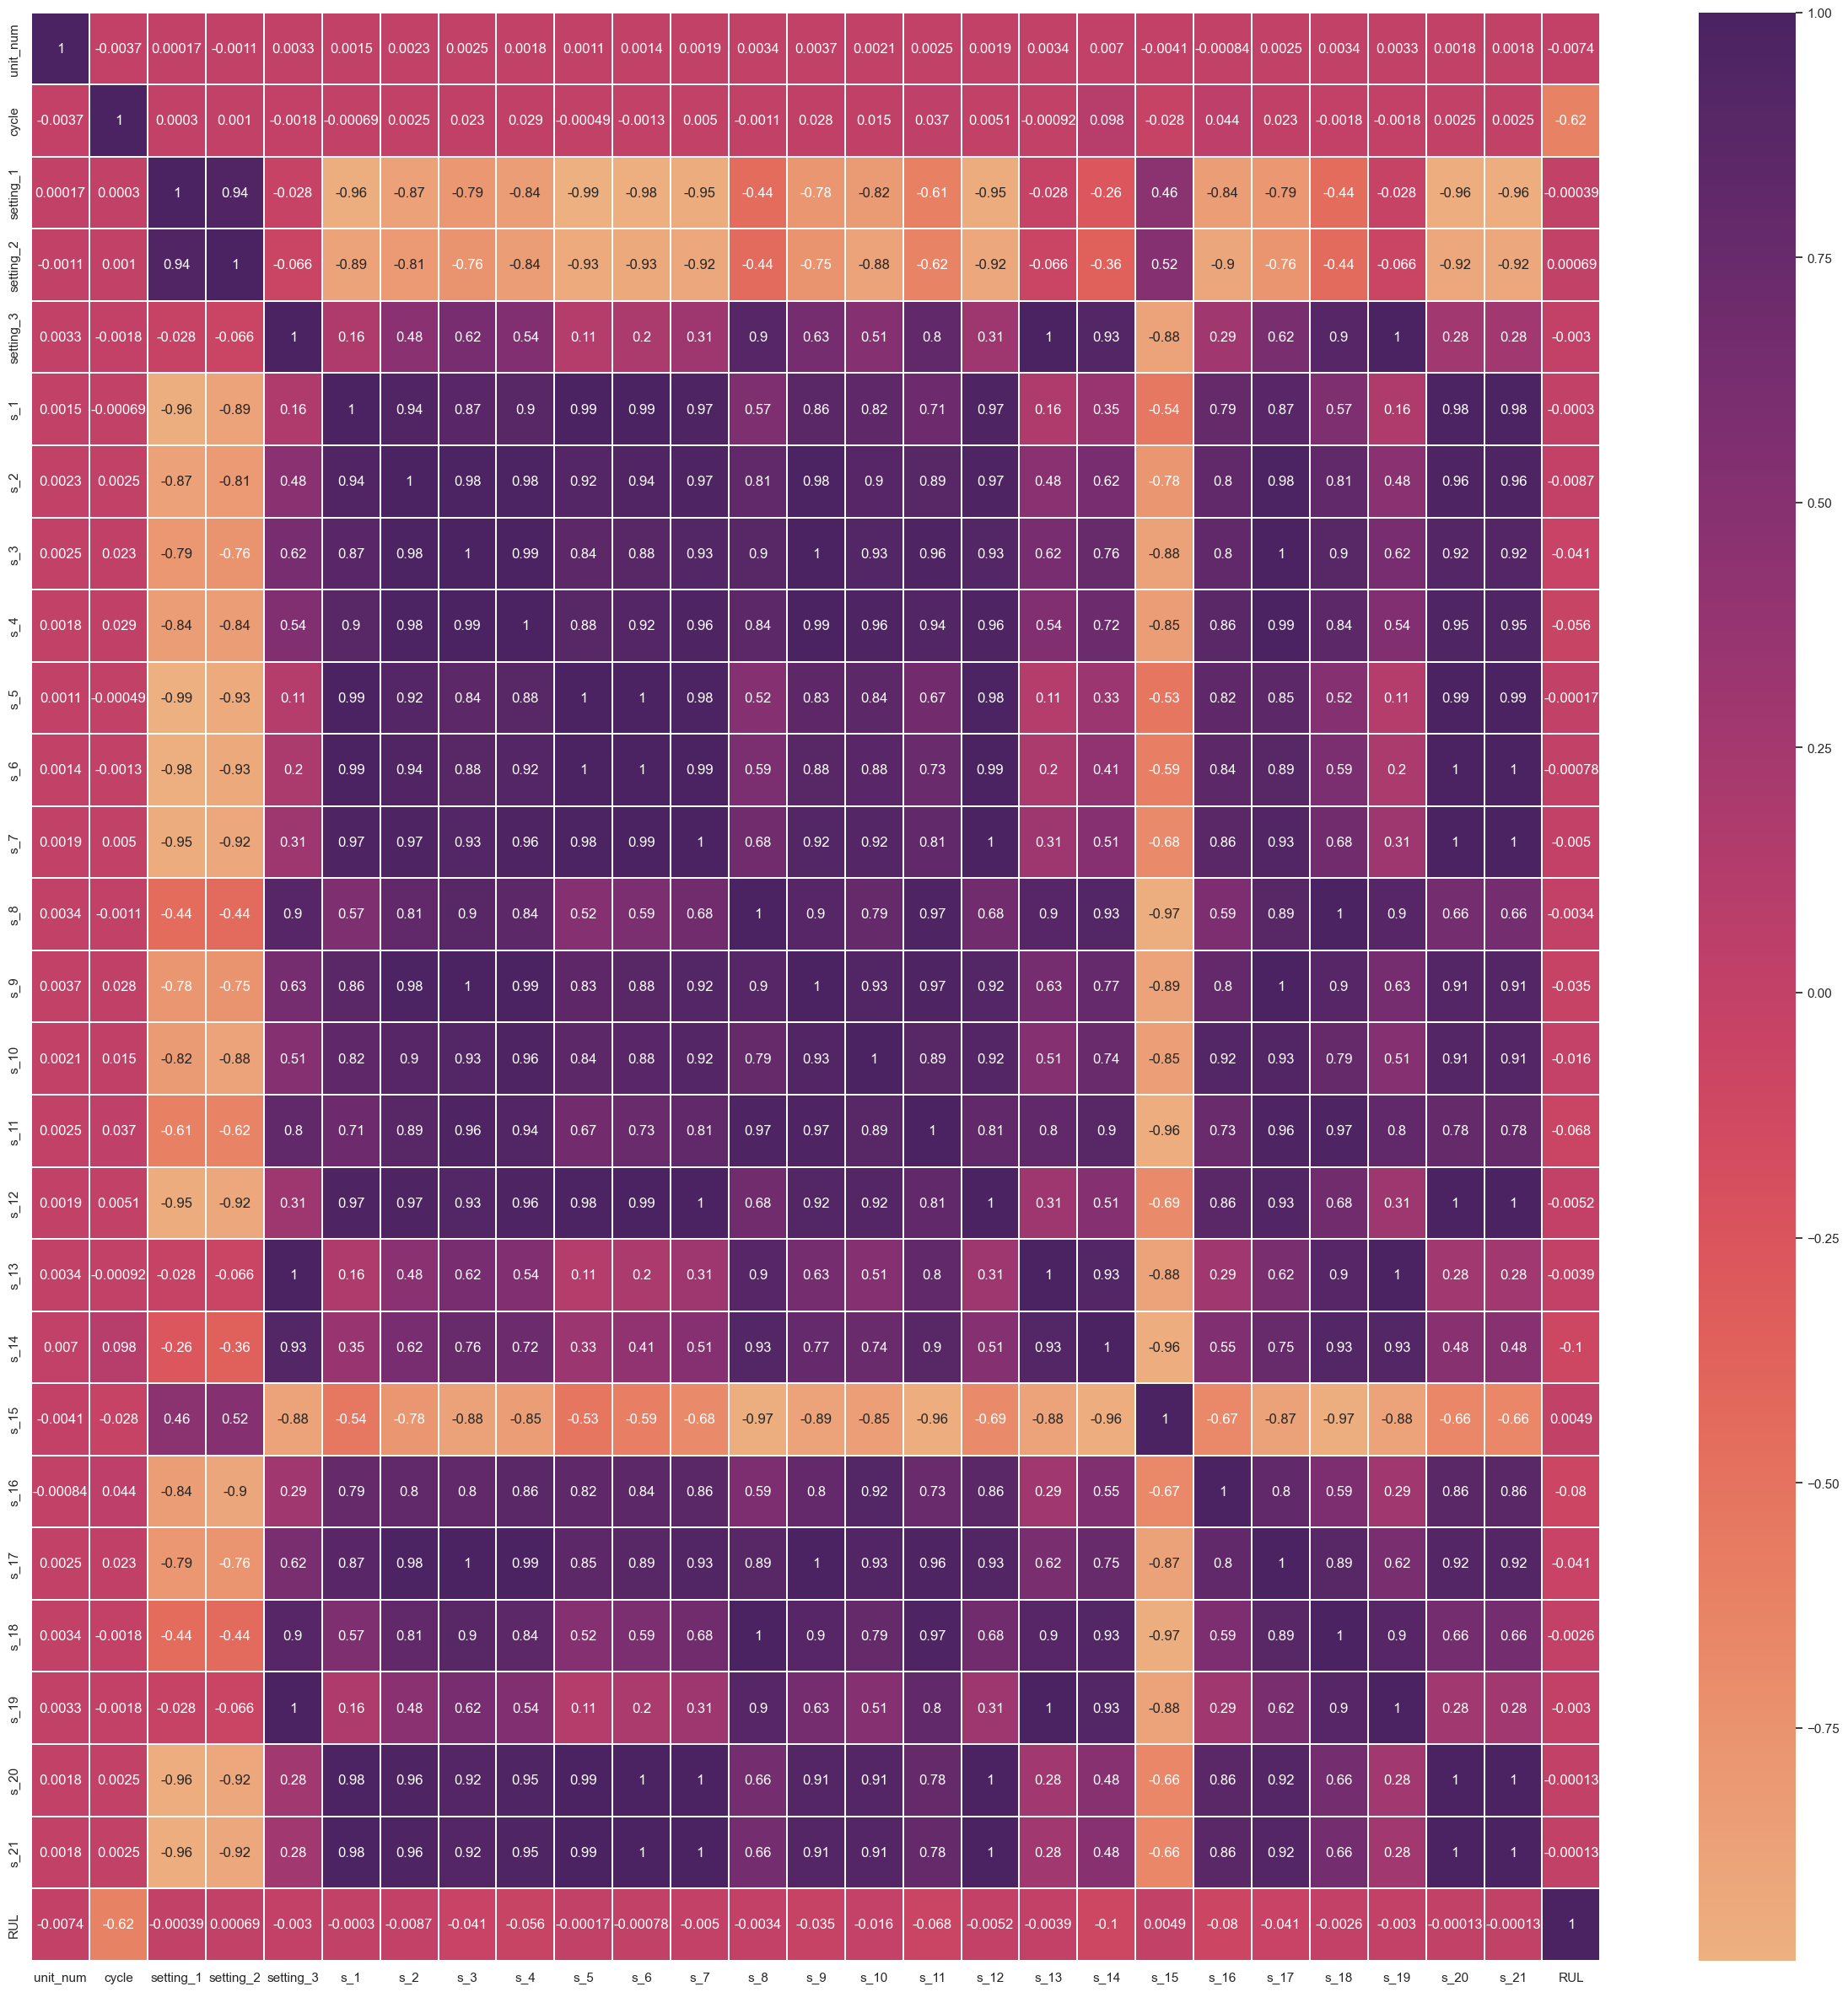

In [70]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(),annot=True,cmap="flare",linewidths=0.1)
plt.show()

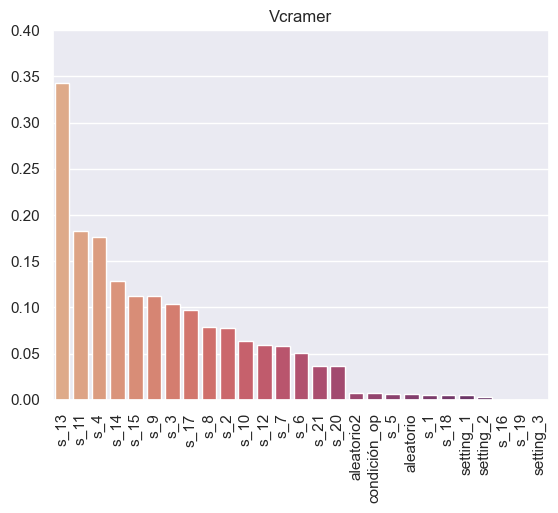

In [72]:
def Vcramer(v, target):
    if v.dtype.kind == "i" or v.dtype.kind == "f":
        v = pd.cut(v, bins=np.unique(np.percentile(v, q=np.arange(0, 101, 20))), include_lowest=True)
    if target.dtype.kind == "i" or target.dtype.kind == "f":
        target = pd.cut(target, bins=np.unique(np.percentile(target, q=np.arange(0, 101, 20))), include_lowest=True)
    confusion_table = pd.crosstab(v, target)
    chi2 = chi2_contingency(confusion_table)[0]
    n = confusion_table.sum().sum()
    cramer_v = np.sqrt(chi2 / (n * min(confusion_table.shape) - 1))
    return cramer_v

def graficoVcramer(matriz, target):
    salidaVcramer = matriz.apply(lambda x: Vcramer(x, target))
    salidaVcramer_sorted = salidaVcramer.sort_values(ascending=False)
    sns.barplot(x=salidaVcramer_sorted.index, y=salidaVcramer_sorted.values, palette="flare")
    plt.xticks(rotation="vertical")
    plt.ylim([0, 0.4])
    plt.title("Vcramer")
    plt.show()

target = train["RUL"].copy()
input = train.copy().drop(labels=["cycle","unit_num","RUL"],axis=1)
input["aleatorio"] = np.random.uniform(size=len(input))
input["aleatorio2"] = np.random.uniform(size=len(input))

graficoVcramer(input, target)


El gráfico anterior reafirma algunos aspectos ya remarcados, como el poco impacto de los sensores 1,5,16,18 y 19. El V de cramer obtenido para cualquiera de ellas es menor que el obtenido con variables generadas de forma aleatoria.

In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 12px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))